<a href="https://colab.research.google.com/github/RegisKonan/Computer_Vision/blob/main/src/b%3D1_Study_the_impact_of_%24_beta%24_on_VAE_loss_and_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with $\beta$-Variational AutoEncoder with $\beta$ = 1

## Setup

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
from IPython.display import display

import numpy as np
import copy
import sys
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tnrange

 ## Training and evaluation functions

 ## Training and evaluation functions VAE

In [ ]:
def train_VAE_model(model, train_loader,val_loader, test_loader, VAE_criterion,eval_criterions, optimizer, device, epochs, VAE_likelihood, beta, L, fold):
    outputs = []

    average_recons_losses = []  # List to store average reconstruction losses
    average_kld_losses = []     # List to store average KLD losses
    average_vae_losses = []         # List to store average total losses
    average_vae_val_losses = []
    average_recons_val_losses = []
    average_kld_val_losses = []
    average_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_vae_loss = 0.0
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        for images, _ in train_loader:
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out  = model(x_in, L)
            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)
            optimizer.zero_grad()
            vae_loss.backward()
            optimizer.step()
            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

        average_recons_loss = total_recons_loss / len(train_loader)
        average_kld_loss = total_kld_loss / len(train_loader)
        average_vae_loss = total_vae_loss / len(train_loader)

        average_recons_losses.append(average_recons_loss)
        average_kld_losses.append(average_kld_loss)
        average_vae_losses.append(average_vae_loss)


        print(f'Train Fold/Epoch: {fold + 1}/{epoch + 1}, Training Loss:{average_vae_loss:.6f}, Training Recons Loss: {average_recons_loss:.6f}, Training KLD Loss: {average_kld_loss:.6f}')


        # Validation phase

        average_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss = eval_VAE_model(fold, model, val_loader, eval_criterions, VAE_likelihood, beta, L, device)
        average_loss_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in average_loss.items()}
        average_vae_val_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in average_vae_val_loss.items()}
        average_recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in average_recons_val_loss.items()}
        average_kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in average_kld_val_loss.items()}


        average_val_losses.append(average_loss_0)
        average_vae_val_losses.append(average_vae_val_losses_1)
        average_recons_val_losses.append(average_recons_val_losses_2)
        average_kld_val_losses.append(average_kld_val_losses_3)

        print(f'Validation Fold/Epoch: {fold + 1}/{epoch + 1},  Validation Loss: {average_loss_0}, Validation VAE Loss: {average_vae_val_losses_1}, Validation Recons Loss: {average_recons_val_losses_2}, Validation KLD Loss: {average_kld_val_losses_3}')



        outputs.append((epoch, x_in, x_out))


    return outputs, average_vae_losses, average_recons_losses, average_kld_losses, average_val_losses, average_vae_val_losses, average_recons_val_losses, average_kld_val_losses

### Visualize reconstructions function VAE

In [ ]:
def VAE_visualize_original_images(test_loader, img_shape, num_samples=10, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.view(-1, img_shape[0] * img_shape[1])
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    plt.suptitle('Visualizing Original Images', fontsize=12)

    for i in range(num_samples):
        ax = plt.subplot(2, num_samples, i + 1)
        # Check if there is only one image in the batch
        if len(batch_features) == 1:
            plt.imshow(batch_features[0].numpy().reshape(img_shape))
        else:
            plt.imshow(batch_features[i].numpy().reshape(img_shape))
        plt.axis('off')

    plt.show()
def VAE_visualize_reconstructions(model, test_loader, img_shape, L, device, num_samples=10, fold_index=None, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.to(device)
            x_in = batch_features.view(batch_features.size(0), -1)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    for i, (item_in, item_out) in enumerate(zip(x_in.cpu().numpy(), x_out.cpu().numpy())):
        if i >= num_samples:
            break
        # Plot original image
        if fold_index == 0:
          plt.subplot(2, num_samples, i + 1)
          item_in = item_in.reshape(img_shape)
          plt.imshow(item_in)
          plt.axis('off')

        # Plot reconstructed image for all folds
        plt.subplot(2, num_samples, num_samples + i + 1)
        item_out = item_out.reshape(img_shape)
        plt.imshow(item_out)
        plt.axis('off')

    plt.show()
img_shape = (28, 28)

### Evaluation functions VAE

In [ ]:
def eval_VAE_model(fold, model, test_loader, criterions, VAE_likelihood, beta, L, device):
    model.eval()
    criterion_names = list(criterions.keys())

    average_vae_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_recons_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_kld_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}

    average_total_loss = {criterion_name: 0.0 for criterion_name in criterion_names}


    for name, criterion in criterions.items():
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        total_vae_loss = 0.0

        total_loss = 0.0

        for (images, _) in test_loader:
            #x_in = Variable(images.view(images.size(0), -1))
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            x_out_flat = x_out.view(x_in.size()).to(device)

            loss = criterion(x_out_flat , x_in)

            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)

            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

            total_loss += loss.item()

        # Calculate the average loss for this criterion
        average_recons_loss = total_recons_loss / len(test_loader)
        average_kld_loss = total_kld_loss / len(test_loader)
        average_vae_loss = total_vae_loss / len(test_loader)

        average_loss = total_loss / len(test_loader)

        # Update the dictionaries with the average values
        average_vae_val_loss[name] = average_vae_loss
        average_recons_val_loss[name] = average_recons_loss
        average_kld_val_loss[name] = average_kld_loss

        average_total_loss[name] = average_loss

    return average_total_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss


## Model definitions: Pytorch Classes

## Variational Autoencoder

Code Regis Djaha

In [ ]:
# Encoder class used in VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Encoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Encoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes

        encoder_layers = []
        for i in range(1, len(encoder_hidden_sizes) - 1):
            # Remove activation at the last layer of the encoder
            if i == len(encoder_hidden_sizes) - 2:
                self.fc_mean = nn.Linear(encoder_hidden_sizes[i], D_z)
                self.fc_logvar = nn.Linear(encoder_hidden_sizes[i], D_z)
            else:
                encoder_layers.extend([nn.Linear(encoder_hidden_sizes[i], encoder_hidden_sizes[i + 1]), activation()])
        #encoder_layers.pop()
        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x_in):
        encoded = self.encoder(x_in)
        z_mean = self.fc_mean(encoded)
        z_logvar = self.fc_logvar(encoded)

        return z_mean,z_logvar


In [ ]:
# Decoder of the VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Decoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Decoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes
        decoder_hidden_sizes = encoder_hidden_sizes[::-1]

        decoder_layers = []
        for i in range(0, len(decoder_hidden_sizes) - 2):
            if i == len(decoder_hidden_sizes) - 3:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), nn.Sigmoid()])
            else:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), activation()])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, z):
      x_out = self.decoder(z)
      return x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))


In [ ]:
# Full VAE model, based on encoder/decoder above
class VAE(nn.Module):
    def __init__(self, D_x=784, n_layers=1, D_z=2, activation=nn.ReLU):
        super(VAE, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        encoder = Encoder(D_x, D_z, n_layers, activation)
        decoder = Decoder(D_x, D_z, n_layers, activation)

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x_in):
        return self.encoder(x_in)

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, mean, logvar):
        sd = torch.exp(logvar * 0.5)
        epsilon = torch.randn_like(sd)
        z = epsilon.mul(sd).add_(mean)
        return z

    def forward(self, x_in, L=1):
        z_mean, z_logvar = self.encode(x_in)
        z_samples = []
        for _ in range(L):
            z = self.reparameterization(z_mean, z_logvar)
            z_samples.append(z)
        z_samples = torch.cat(z_samples, dim=0)
        x_out = self.decode(z_samples)
        x_out = x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))
        return z_mean, z_logvar, z_samples, x_out

### VAE_criterion

In [ ]:
# VAE Criterion, as combination of reconstruction loss and KL divergence
# Note that the reconstruction loss can be based on the Gaussian or Bernoulli likelihood
# Note that the KL divergence term can be weighted by the input $\beta$ parameter
def VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta=1.0):
    recons_losses = []  # Store individual reconstruction losses

    if VAE_likelihood == "gaussian":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the mean squared error (MSE) loss for each sample
            recons_loss = F.mse_loss(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)
    elif VAE_likelihood == "bernoulli":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the binary cross-entropy loss for each sample
            recons_loss = F.binary_cross_entropy(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)

    # Calculate the mean loss over the L samples
    recons_loss = (1 / L) * sum(recons_losses)/ x_out.size(0)

    kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())/ x_out.size(0)

    loss = (recons_loss + beta * kld_loss)

    return recons_loss, kld_loss, loss


### latent space VAE model

In [ ]:
def latent_space_VAE_model(model, test_loader, device, number_fold):
    model.eval()
    latent_variables = []
    labels = []

    for images, _ in test_loader:
        x_in = images.view(images.size(0), -1).to(device)
        with torch.no_grad():
            z_mean, z_logvar = model.encode(x_in)
            z = model.reparameterization(z_mean, z_logvar)
        latent_variables.append(z.cpu().numpy())
        labels.append(_.numpy())

    latent_variables = np.concatenate(latent_variables)
    labels = np.concatenate(labels)

    colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
    colors = colormap(labels)

    # Scatter plot for latente space on the left
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    scatter_latent_variables = ax1.scatter(latent_variables[:, 0], latent_variables[:, 1], c=labels, cmap=colormap)
    ax1.set_xlabel("Latent Space 1")
    ax1.set_ylabel("Latent Space 2")
    ax1.set_title(f'Latent Space (z_size = {model.D_z}) for fold {number_fold}')
    cbar_mean = plt.colorbar(scatter_latent_variables)

    # Plot the distribution of the first latent variable (z[0]) on the right
    ax2.hist(latent_variables[:, 0], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 1')
    ax3.hist(latent_variables[:, 1], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 2')

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    x = np.linspace(-5, 5, 1000)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    ax2.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax2.set_xlabel("Latent Space")
    ax2.set_ylabel("Density")
    ax2.set_title(f'Distribution of Latent Space 1 (z_size = {model.D_z}) for fold {number_fold}')
    ax2.legend()

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    ax3.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax3.set_xlabel("Latent Space")
    ax3.set_ylabel("Density")
    ax3.set_title(f'Distribution of Latent Space 2 (z_size = {model.D_z}) for fold {number_fold}')
    ax3.legend()


    plt.tight_layout()
    plt.show()




### VAE k_fold_cross_validation

In [ ]:
def VAE_k_fold_cross_validation(model_class, model_config, train_dataset, test_dataset, VAE_criterion, learning_rate, training_setup, beta,  L, k_folds, batch_size,
                            eval_criterions={
        'MSE': torch.nn.MSELoss(),
        'L1 Loss': torch.nn.L1Loss(),
        'BCE': torch.nn.BCELoss()
    }):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a list to store models and losses
    models = []
    fold_results = []

    # Perform k-fold cross-validation
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Split dataset into training and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)

        # Create data loaders
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        print(len(train_loader_fold.dataset))
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        print(len(val_loader_fold.dataset))
        test_loader_fold = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(test_loader_fold.dataset)

        # Initialize autoencoder model

        model = model_class(**model_config).to(training_setup['device'])

        # Define loss function and optimizer after initializing the model
        criterion = VAE_criterion
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize test_losses_fold
        test_losses_fold_1 = []
        test_vae_losses_fold_1 = []
        test_recons_losses_fold_1 = []
        test_kld_losses_fold_1 = []
        val_losses_fold_1 = []
        val_vae_losses_fold_1 = []
        val_recons_losses_fold_1 = []
        val_kld_losses_fold_1 = []

        # Train the model for k-fold cross-validation
        train_outputs_fold, train_vae_losses_fold, train_recons_losses_fold, train_kld_losses_fold, val_losses_fold, val_vae_losses_fold, val_recons_losses_fold, val_kld_losses_fold = train_VAE_model(
            model,
            train_loader_fold,
            val_loader_fold,
            test_loader_fold,
            criterion,
            eval_criterions,
            optimizer,
            training_setup['device'],
            training_setup['epochs'],
            training_setup['VAE_likelihood'],
            beta,
            L,
            fold
        )
        # Test and validate the model for k-fold cross-validation
        val_losses_fold_1, val_vae_losses_fold_1, val_recons_losses_fold_1, val_kld_losses_fold_1 = eval_VAE_model(fold,
                                           model,
                                           val_loader_fold,
                                           eval_criterions,
                                           training_setup['VAE_likelihood'],
                                           beta,
                                           L,
                                           training_setup['device'])
        val_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in val_losses_fold_1.items()}
        val_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in val_vae_losses_fold_1.items()}
        recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in val_recons_losses_fold_1.items()}
        kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in val_kld_losses_fold_1.items()}
        print(f'Validation results for fold {fold +1}, Validation Loss: {val_losses_0}, Validation Average VAE Loss: {val_vae_losses_1}, Validation Average Recons Loss: {recons_val_losses_2}, Validation Average KLD Loss: {kld_val_losses_3}')

        test_losses_fold_1, test_vae_losses_fold_1, test_recons_losses_fold_1, test_kld_losses_fold_1 = eval_VAE_model(fold,
                                                                                   model,
                                                                                   test_loader_fold,
                                                                                   eval_criterions,
                                                                                   training_setup['VAE_likelihood'],
                                                                                   beta,
                                                                                   L,
                                                                                   training_setup['device'])
        test_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in test_losses_fold_1.items()}
        test_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in test_vae_losses_fold_1.items()}
        recons_test_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in test_recons_losses_fold_1.items()}
        kld_test_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in test_kld_losses_fold_1.items()}
        print(f'Test results for fold {fold +1}, Testing Loss: {test_losses_0}, Testing Average VAE Loss: {test_vae_losses_1}, Testing Average Recons Loss: {recons_test_losses_2}, Testing Average KLD Loss: {kld_test_losses_3}')


        # Save the model from this fold
        models.append(model)
        fold_results.append({
            "outputs": train_outputs_fold,
            "train_recons_losses_fold": train_recons_losses_fold,
            "train_kld_losses_fold": train_kld_losses_fold,
            "train_losses_fold": train_vae_losses_fold,
            "val_fold": val_losses_fold,
            "val_losses_fold": val_vae_losses_fold,
            "val_recons_losses_fold": val_recons_losses_fold,
            "val_kld_losses_fold": val_kld_losses_fold,
            "metrics_val_results": val_losses_0,
            "val_results": val_vae_losses_1 ,
            "val_recons_results": recons_val_losses_2,
            "val_kld_results": kld_val_losses_3,
            "metrics_test_results": test_losses_0,
            "test_results": test_vae_losses_1,
            "test_recons_results": recons_test_losses_2,
            "test_kld_results": kld_test_losses_3,
        })

    return models, fold_results


## plot mean and std VAE

In [ ]:
def VAE_plot_mean_std(data, title, ax, label, epochs, plot_std=True):
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    ax.plot(epochs, mean_data, label=label)

    if plot_std:
        ax.fill_between(
            epochs,
            mean_data - std_data,
            mean_data + std_data,
            alpha=0.3,
            label='Standard Deviation'
        )

    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis ticks to integers

def VAE_plot_results(kfold_results, loss_type='MSE'):

    # trin each epoch
    train_losses = []
    train_recons_losses = []
    train_kld_losses = []

    # valid each epoch
    val_losses = []
    val_recons_losses = []
    val_kld_losses = []

    # valid result
    valid_result = []
    recons_valid_result = []
    kld_valid_result = []

    # test result
    test_result = []
    recons_test_result = []
    kld_test_result = []

    # valid results metrics
    valid_metrics = []

    # test result metrics
    test_metrics = []

    epochs = None

    for fold_result in kfold_results:
        train_losses.append(fold_result['train_losses_fold'])
        train_recons_losses.append(fold_result['train_recons_losses_fold'])
        train_kld_losses.append(fold_result['train_kld_losses_fold'])


        if isinstance(fold_result['val_losses_fold'], list):
            val_losses.append([val[loss_type] for val in fold_result['val_losses_fold']])
        else:
            val_losses.append(fold_result['val_losses_fold'][loss_type])

        if isinstance(fold_result['val_recons_losses_fold'], list):
            val_recons_losses.append([val[loss_type] for val in fold_result['val_recons_losses_fold']])
        else:
            val_recons_losses.append(fold_result['val_recons_losses_fold'][loss_type])

        if isinstance(fold_result['val_kld_losses_fold'], list):
            val_kld_losses.append([val[loss_type] for val in fold_result['val_kld_losses_fold']])
        else:
            val_kld_losses.append(fold_result['val_kld_losses_fold'][loss_type])

            # valid result

        if isinstance(fold_result['val_results'], list):
            valid_result.append([val[loss_type] for val in fold_result['val_results']])
        else:
            valid_result.append(fold_result['val_results'][loss_type])

        if isinstance(fold_result['val_recons_results'], list):
            recons_valid_result.append([val[loss_type] for val in fold_result['val_recons_results']])
        else:
            recons_valid_result.append(fold_result['val_recons_results'][loss_type])

        if isinstance(fold_result['val_kld_results'], list):
            kld_valid_result.append([val[loss_type] for val in fold_result['val_kld_results']])
        else:
            kld_valid_result.append(fold_result['val_kld_results'][loss_type])

        # test result
        if isinstance(fold_result['test_results'], list):
            test_result.append([val[loss_type] for val in fold_result['test_results']])
        else:
            test_result.append(fold_result['test_results'][loss_type])

        if isinstance(fold_result['test_recons_results'], list):
            recons_test_result.append([val[loss_type] for val in fold_result['test_recons_results']])
        else:
            recons_test_result.append(fold_result['test_recons_results'][loss_type])

        if isinstance(fold_result['test_kld_results'], list):
            kld_test_result.append([val[loss_type] for val in fold_result['test_kld_results']])
        else:
            kld_test_result.append(fold_result['test_kld_results'][loss_type])

            # valid results metrics

         # valid result
        if isinstance(fold_result['metrics_val_results'], list):
            valid_metrics.append([val[loss_type] for val in fold_result['metrics_val_results']])
        else:
            valid_metrics.append(fold_result['metrics_val_results'][loss_type])

        # test result
        if isinstance(fold_result['metrics_test_results'], list):
            test_metrics.append([val[loss_type] for val in fold_result['metrics_test_results']])
        else:
            test_metrics.append(fold_result['metrics_test_results'][loss_type])

        if epochs is None:
            epochs = np.arange(1, len(train_recons_losses[0]) + 1)

    # Convert lists to numpy arrays
    train_losses = np.array(train_losses)
    train_recons_losses = np.array(train_recons_losses)
    train_kld_losses = np.array(train_kld_losses)


    val_losses = np.array(val_losses)
    val_recons_losses = np.array(val_recons_losses)
    val_kld_losses = np.array(val_kld_losses)

    valid_result = np.array(valid_result)
    recons_valid_result = np.array(recons_valid_result)
    kld_valid_result = np.array(kld_valid_result)

    test_result = np.array(test_result)
    recons_test_result = np.array(recons_test_result)
    kld_test_result = np.array(kld_test_result)

    valid_metrics = np.array(valid_metrics)
    test_metrics = np.array(test_metrics)

     # Calculate mean for validation
    mean_valid_metrics = np.mean(valid_metrics)
    std_valid_metrics = np.std(valid_metrics)

    mean_valid_result = np.mean(valid_result)
    std_valid_result = np.std(valid_result)

    mean_recons_valid_result = np.mean(recons_valid_result)
    std_recons_valid_result = np.std(recons_valid_result)

    mean_kld_valid_result = np.mean(kld_valid_result)
    std_kld_valid_result = np.std(kld_valid_result)

    # Calculate mean for testing
    mean_test_metrics = np.mean(test_metrics)
    std_test_metrics = np.std(test_metrics)

    mean_test_result = np.mean(test_result)
    std_test_result = np.std(test_result)

    mean_recons_test_result = np.mean(recons_test_result)
    std_recons_test_result = np.std(recons_test_result)

    mean_kld_test_result = np.mean(kld_test_result)
    std_kld_test_result = np.std(kld_test_result)

    return {
        'mean_valid_metrics': mean_valid_metrics,
        'std_valid_metrics': std_valid_metrics,
        'mean_valid_result': mean_valid_result,
        'std_valid_result': std_valid_result,
        'mean_recons_valid_result': mean_recons_valid_result,
        'std_recons_valid_result': std_recons_valid_result,
        'mean_kld_valid_result': mean_kld_valid_result,
        'std_kld_valid_result': std_kld_valid_result,
        'mean_test_metrics ': mean_test_metrics ,
        'std_test_metrics': std_test_metrics,
        'mean_test_result': mean_test_result,
        'std_test_result': std_test_result,
        'mean_recons_test_result': mean_recons_test_result,
        'std_recons_test_result': std_recons_test_result,
        'mean_kld_test_result': mean_kld_test_result,
        'std_kld_test_result': std_kld_test_result,
        'epochs': epochs,
        'train_losses': train_losses,
        'train_recons_losses':train_recons_losses,
        'train_kld_losses': train_kld_losses,
        'val_losses': val_losses,
        'val_recons_losses': val_recons_losses,
        'val_kld_losses': val_kld_losses,
        'valid_result': valid_result,
        'recons_valid_result': recons_valid_result,
        'kld_valid_result': kld_valid_result,
        'test_result': test_result,
        'recons_test_result': recons_test_result,
        'kld_test_result': kld_test_result,
        'valid_metrics': valid_metrics,
        'test_metrics': test_metrics,
    }
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

def print_evaluation_table(valid_metrics, test_metrics, valid_result, test_result, recons_valid_result, recons_test_result,kld_valid_result, kld_test_result):
    # Calculate mean and standard deviation for Validation Loss and Test Loss
    mean_valid_metrics_loss = np.mean(valid_metrics)
    std_valid_metrics_loss = np.std(valid_metrics)
    mean_valid_loss = np.mean(valid_result)
    std_valid_loss = np.std(valid_result)
    mean_recons_valid_result_loss = np.mean(recons_valid_result)
    std_recons_valid_result_loss = np.std(recons_valid_result)
    mean_kld_valid_result_loss = np.mean(kld_valid_result)
    std_kld_valid_result_loss = np.std(kld_valid_result)

    mean_test_metrics_loss = np.mean(test_metrics)
    std_test_metrics_loss = np.std(test_metrics)
    mean_test_loss = np.mean(test_result)
    std_test_loss = np.std(test_result)
    mean_recons_test_result_loss = np.mean(recons_valid_result)
    std_recons_test_result_loss = np.std(recons_valid_result)
    mean_kld_test_result_loss = np.mean(kld_test_result)
    std_kld_test_result_loss = np.std(kld_test_result)

    # Create a DataFrame for mean and standard deviation
    evaluation_summary_dict = {
    'Metric': ['Mean', 'Standard Deviation'],
    'Validation Metrics Loss': [mean_valid_metrics_loss, std_valid_metrics_loss],
    'Test Metrics Loss': [mean_test_metrics_loss, std_test_metrics_loss],
    'Validation VAE Loss': [mean_valid_loss, std_valid_loss],
    'Test VAE Loss': [mean_test_loss, std_test_loss],
    'Validation Recons Loss': [mean_recons_valid_result_loss, std_recons_valid_result_loss],
    'Test Recons Loss': [mean_recons_test_result_loss, std_recons_test_result_loss],
    'Validation KLD Loss': [mean_kld_valid_result_loss, std_kld_valid_result_loss],
    'Test KLD Loss': [mean_kld_test_result_loss, std_kld_test_result_loss]
}

    df_summary = pd.DataFrame(evaluation_summary_dict)

    # Print the mean and standard deviation table
    print("\nMean and Standard Deviation Table:")
    print(df_summary.to_string(index=False))


    # Print the detailed evaluation table with highlighted rows
    min_val_loss_index = np.argmin(valid_result)
    evaluation_dict = {
        'Fold': np.arange(1, len(valid_result) + 1),
        'Validation Metrics Loss': valid_metrics,
        'Test Metrics Loss': test_metrics,
        'Validation Loss': valid_result,
        'Test Loss': test_result
    }

    df = pd.DataFrame(evaluation_dict)


    # Display the Detailed Evaluation Table with proper styling
    styles = [
        dict(selector=f'.row{min_val_loss_index + 2}', props=[('background-color', 'lightgreen')])
    ]
    #df_styled = df.style.set_table_styles(styles, axis=1)
    df_styled = df.style.apply(highlight_min, subset=['Validation Loss'], axis=0)

    print("\nDetailed Evaluation Table:")
    display(df_styled)

## Experiments with MNIST

### Set our seed and other configurations for reproducibility.

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Dataset

#### We load our MNIST dataset using the torchvision package.

#### We need to specify the batch size for the dataloader first

In [ ]:
batch_size=64

In [ ]:
# Load MNIST Training data
# Note that we shuffle the training data
train_loader = DataLoader(
    MNIST(
      root='./data',
      train=True,
      download=True,
      transform=transforms.ToTensor()),
       batch_size=batch_size,
       shuffle=True
    )

100%|██████████| 9912422/9912422 [00:00<00:00, 38787763.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58378647.63it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11520303.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1943733.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Load MNIST Test data
# Note that we DO NOT shuffle the test data
test_loader = DataLoader(
    MNIST(
      root='./data',
      train=False,
      download=True,
      transform=transforms.ToTensor()),
      batch_size=batch_size,
      shuffle=False
    )

#### Total number of images in the training and testing sets

In [ ]:
print("Total number of training images:", len(train_loader.dataset))
print("Total number of testing images:", len(test_loader.dataset))

Total number of training images: 60000
Total number of testing images: 10000


In [ ]:
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


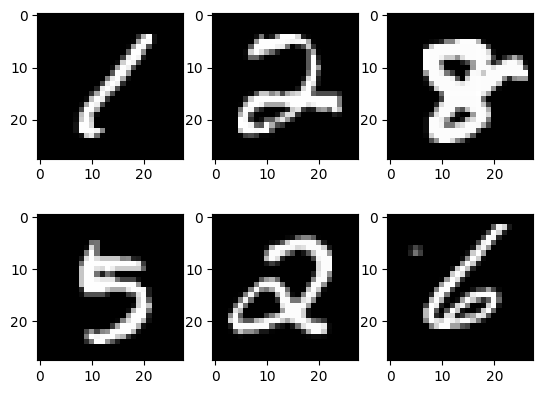

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Experiments with MNIST: Variational Autoencoder

## Test 1: $β$-VAE: *BCE*

### Experiments 1 : VAE with $\beta$ =1 with n_layer=1

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 8, 16, 32, 64}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Gaussian and Bernoulli.

### Experiment 4.1 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_1 = 'VAE'
model_config_4_1 = {'D_x': 784, 'n_layers': 1, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_1, fold_results_4_1 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_1),
                                                model_config=model_config_4_1,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:316.128160, Training Recons Loss: 301.666501, Training KLD Loss: 14.461660
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.0678230744013761, 'L1 Loss': 0.16347913475746803, 'BCE': 0.2739419387059009}, Validation VAE Loss: {'MSE': 231.69323162322348, 'L1 Loss': 231.6575210246634, 'BCE': 231.76062303908327}, Validation Recons Loss: {'MSE': 214.7030886386303, 'L1 Loss': 214.66737820239777, 'BCE': 214.77048005449012}, Validation KLD Loss: {'MSE': 16.990142477319594, 'L1 Loss': 16.990142477319594, 'BCE': 16.990142477319594}
Train Fold/Epoch: 1/2, Training Loss:223.224074, Training Recons Loss: 209.896489, Training KLD Loss: 13.327585
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.0644112681534062, 'L1 Loss': 0.1532112975069817, 'BCE': 0.26000283658504486}, Validation VAE Loss: {'MSE': 21

## Visualizing reconstructions for all fold

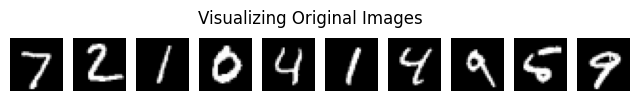

Visualizing reconstructions for fold 1


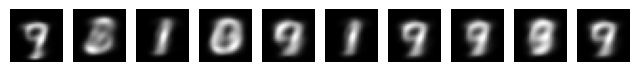

Visualizing reconstructions for fold 2


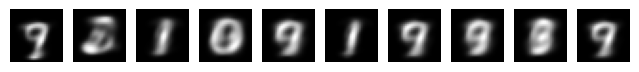

Visualizing reconstructions for fold 3


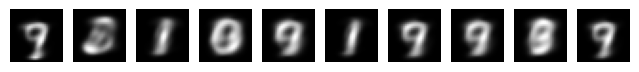

Visualizing reconstructions for fold 4


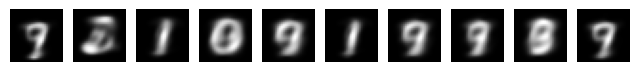

Visualizing reconstructions for fold 5


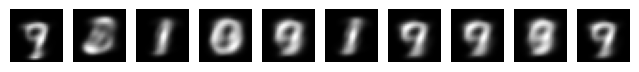

Visualizing reconstructions for fold 6


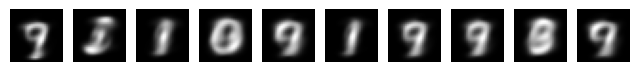

Visualizing reconstructions for fold 7


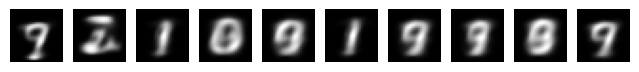

Visualizing reconstructions for fold 8


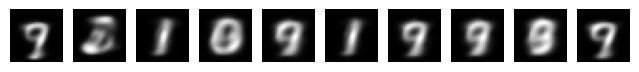

Visualizing reconstructions for fold 9


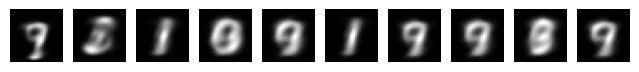

Visualizing reconstructions for fold 10


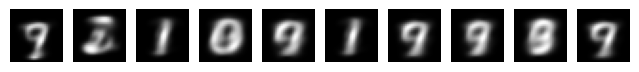

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_1):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

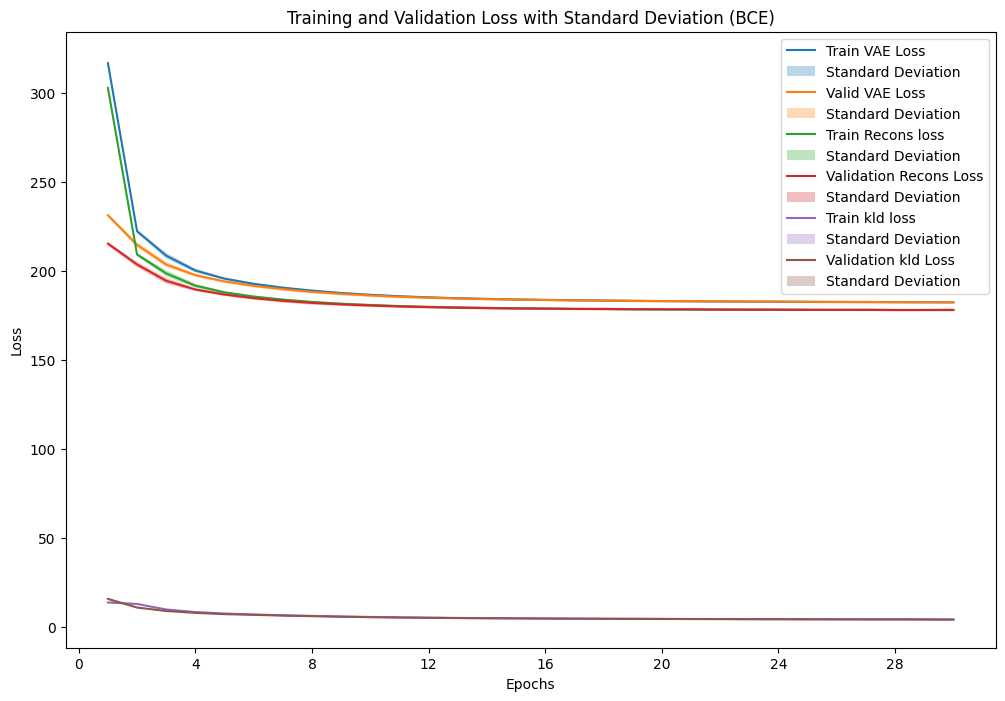

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_1_1 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_1_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_1['epochs'])
VAE_plot_mean_std(result_data_4_1_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_1['epochs'])
VAE_plot_mean_std(result_data_4_1_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_1['epochs'])
VAE_plot_mean_std(result_data_4_1_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_1['epochs'])
VAE_plot_mean_std(result_data_4_1_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_1['epochs'])
VAE_plot_mean_std(result_data_4_1_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_1_1['valid_metrics'],
    result_data_4_1_1['test_metrics'],
    result_data_4_1_1['valid_result'],
    result_data_4_1_1['test_result'],
    result_data_4_1_1['recons_valid_result'],
    result_data_4_1_1['recons_test_result'],
    result_data_4_1_1['kld_valid_result'],
    result_data_4_1_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.227426           0.226353           182.572699     181.745704              178.301603        178.301603             4.271097       4.285325
Standard Deviation                 0.000807           0.000118             0.630999       0.099063                0.632306          0.632306             0.057284       0.057360

Detailed Evaluation Table:


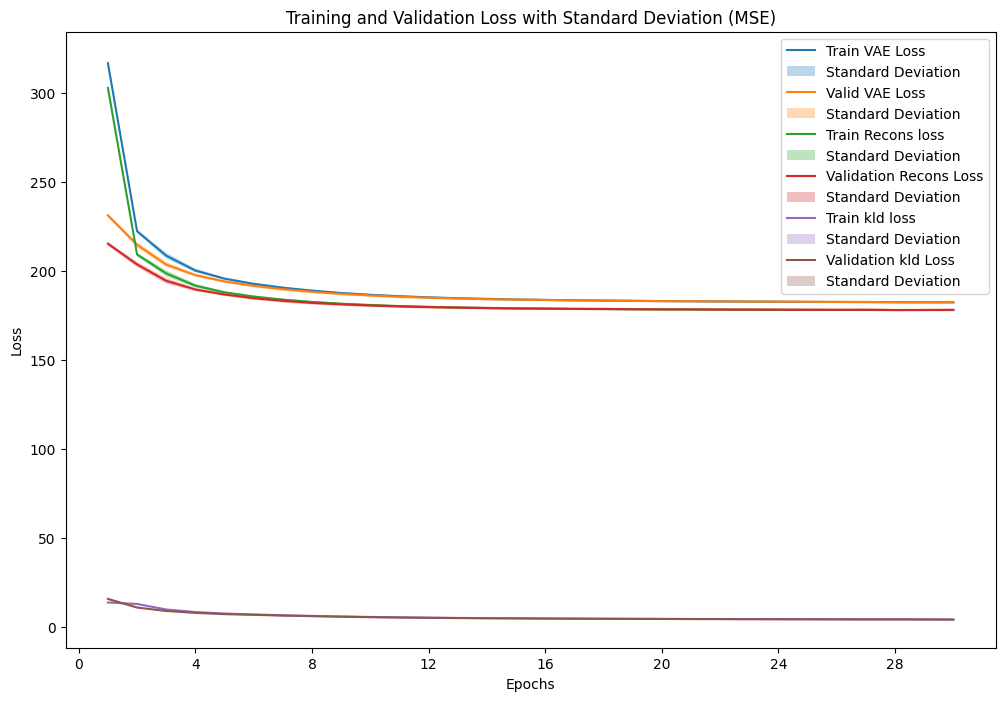

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_1_2 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_1_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_2['epochs'])
VAE_plot_mean_std(result_data_4_1_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_2['epochs'])
VAE_plot_mean_std(result_data_4_1_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_2['epochs'])
VAE_plot_mean_std(result_data_4_1_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_2['epochs'])
VAE_plot_mean_std(result_data_4_1_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_2['epochs'])
VAE_plot_mean_std(result_data_4_1_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_1_2['valid_metrics'],
    result_data_4_1_2['test_metrics'],
    result_data_4_1_2['valid_result'],
    result_data_4_1_2['test_result'],
    result_data_4_1_2['recons_valid_result'],
    result_data_4_1_2['recons_test_result'],
    result_data_4_1_2['kld_valid_result'],
    result_data_4_1_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.056009           0.055780           182.549338     181.750869              178.278241        178.278241             4.271097       4.285325
Standard Deviation                 0.000244           0.000033             0.643196       0.096689                0.644734          0.644734             0.057284       0.057360

Detailed Evaluation Table:


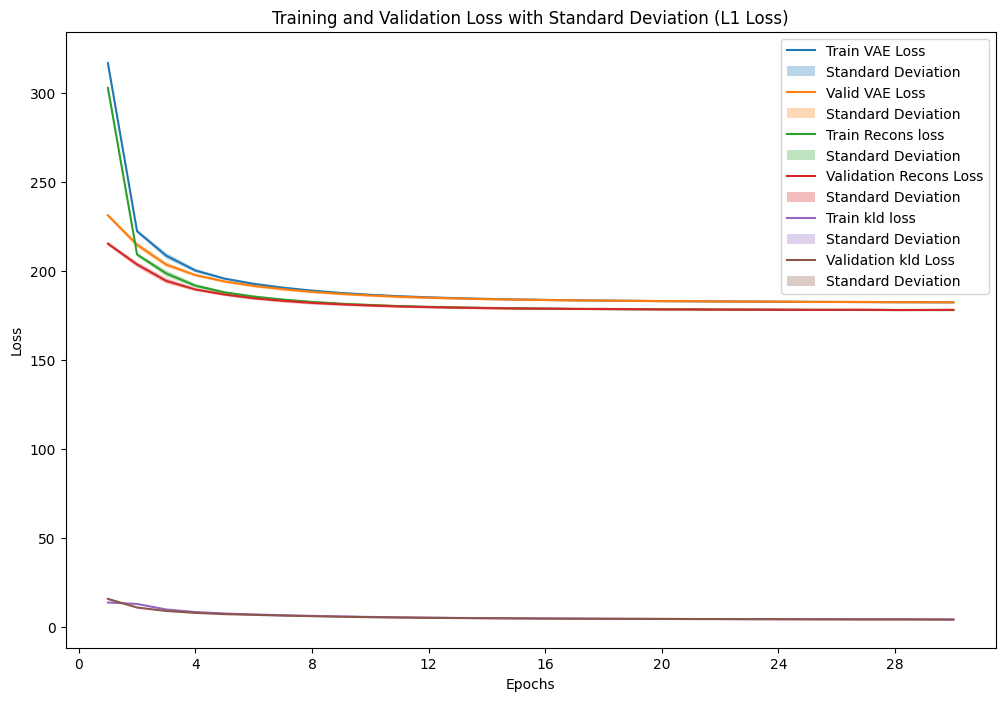

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_1_3 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_1_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_3['epochs'])
VAE_plot_mean_std(result_data_4_1_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_3['epochs'])
VAE_plot_mean_std(result_data_4_1_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_3['epochs'])
VAE_plot_mean_std(result_data_4_1_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_3['epochs'])
VAE_plot_mean_std(result_data_4_1_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_3['epochs'])
VAE_plot_mean_std(result_data_4_1_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_1_3['valid_metrics'],
    result_data_4_1_3['test_metrics'],
    result_data_4_1_3['valid_result'],
    result_data_4_1_3['test_result'],
    result_data_4_1_3['recons_valid_result'],
    result_data_4_1_3['recons_test_result'],
    result_data_4_1_3['kld_valid_result'],
    result_data_4_1_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.126985           0.126821           182.556224     181.738703              178.285127        178.285127             4.271097       4.285325
Standard Deviation                 0.000698           0.000483             0.622130       0.105947                0.622890          0.622890             0.057284       0.057360

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_1 = sum(p.numel() for p in models_4_1[0].parameters())
print(f"Number of parameters in the model: {total_params_4_1}")

Number of parameters in the model: 5492


<ipython-input-17-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


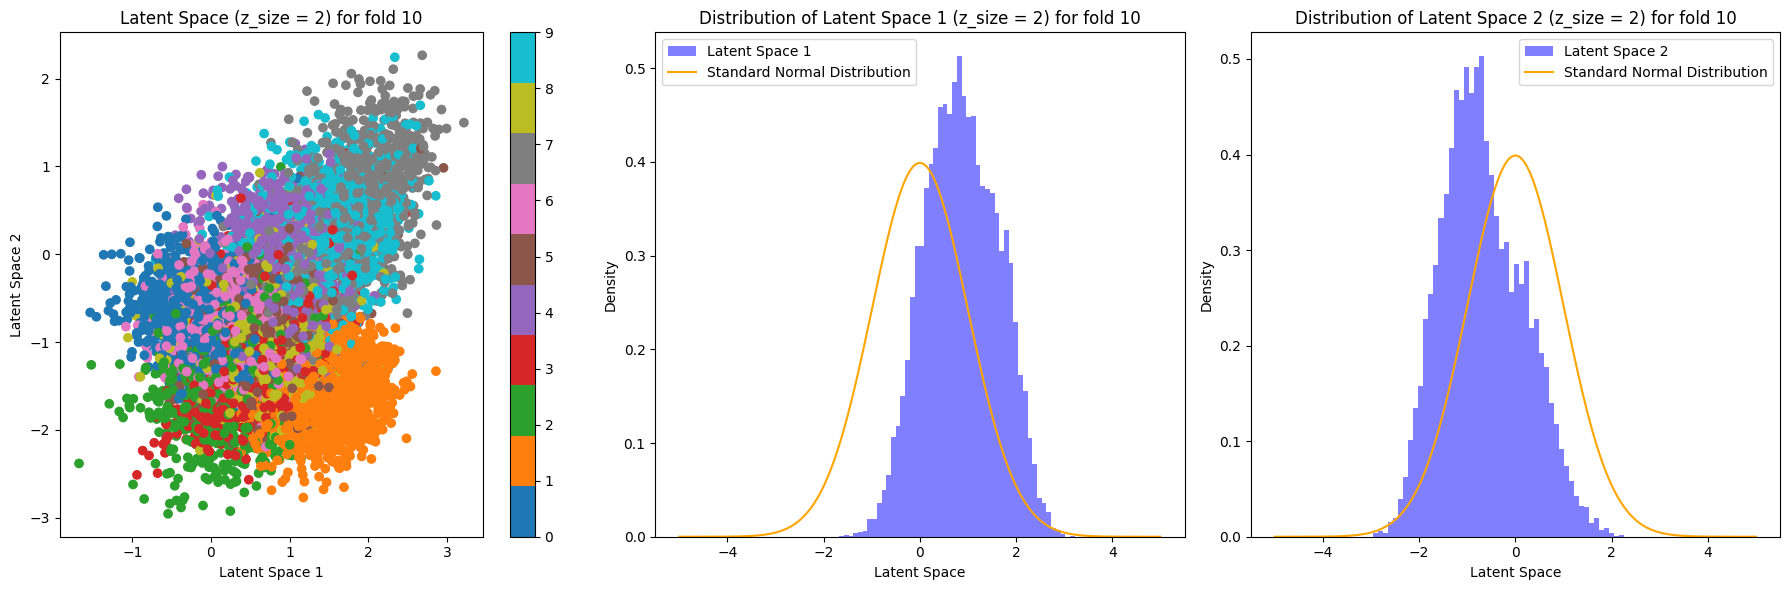

In [ ]:
latent_space_VAE_model(models_4_1[9], test_loader, device, number_fold=10)

### Experiment 4.3 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_3 = 'VAE'
model_config_4_3 = {'D_x': 784, 'n_layers': 1, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_3, fold_results_4_3 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_3),
                                                model_config=model_config_4_3,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:231.725907, Training Recons Loss: 203.006435, Training KLD Loss: 28.719471
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.038754321515877196, 'L1 Loss': 0.10629757842484941, 'BCE': 0.18868578193669625}, Validation VAE Loss: {'MSE': 174.92241847261468, 'L1 Loss': 174.71640680191365, 'BCE': 174.8010948668135}, Validation Recons Loss: {'MSE': 148.05097799098237, 'L1 Loss': 147.84496599562624, 'BCE': 147.929653735871}, Validation KLD Loss: {'MSE': 26.871440623668914, 'L1 Loss': 26.871440623668914, 'BCE': 26.871440623668914}
Train Fold/Epoch: 1/2, Training Loss:160.547361, Training Recons Loss: 133.778513, Training KLD Loss: 26.768848
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.030100102219334308, 'L1 Loss': 0.08393853046792618, 'BCE': 0.15939263777529938}, Validation VAE Loss: {'MSE

## Visualizing reconstructions for all fold

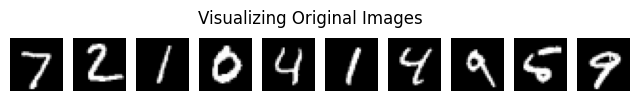

Visualizing reconstructions for fold 1


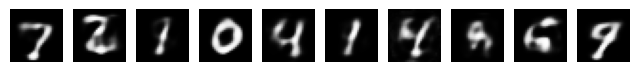

Visualizing reconstructions for fold 2


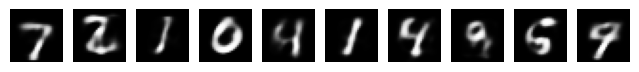

Visualizing reconstructions for fold 3


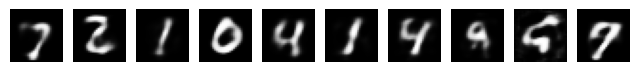

Visualizing reconstructions for fold 4


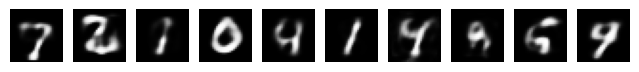

Visualizing reconstructions for fold 5


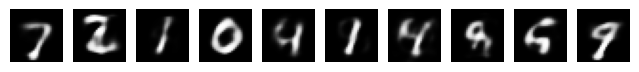

Visualizing reconstructions for fold 6


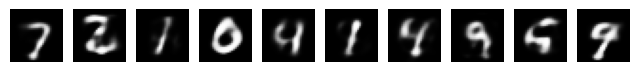

Visualizing reconstructions for fold 7


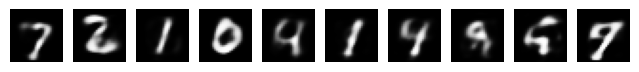

Visualizing reconstructions for fold 8


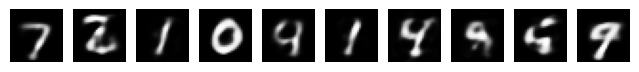

Visualizing reconstructions for fold 9


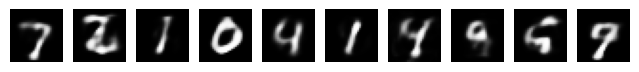

Visualizing reconstructions for fold 10


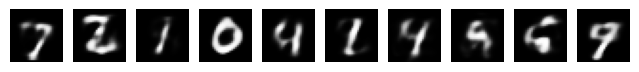

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_3):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

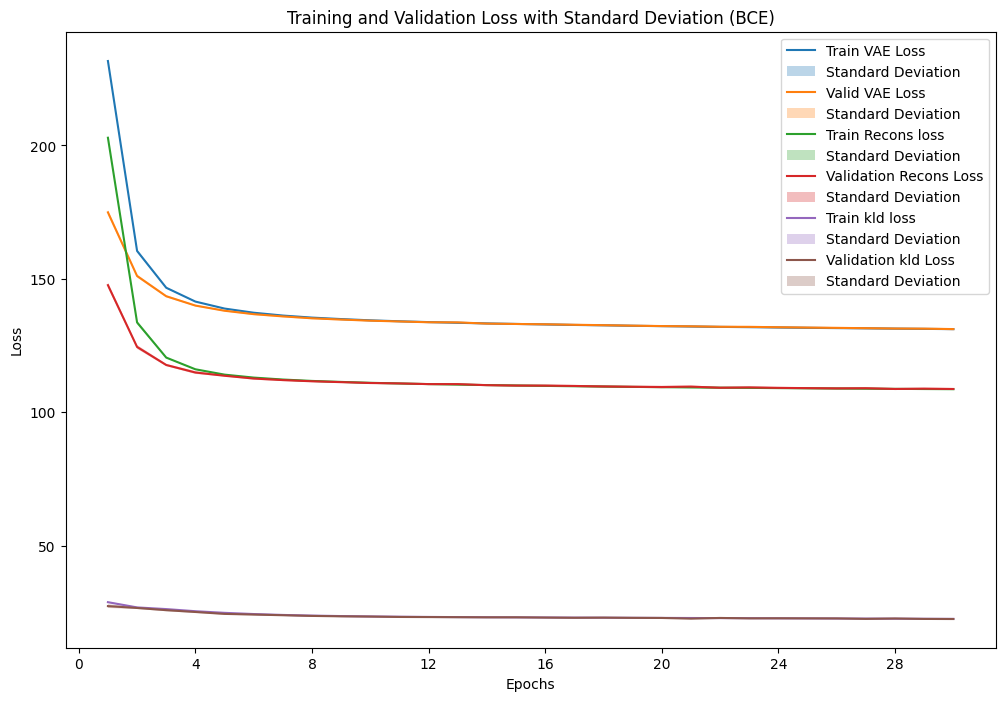

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_3_1 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_3_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_1['epochs'])
VAE_plot_mean_std(result_data_4_3_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_1['epochs'])
VAE_plot_mean_std(result_data_4_3_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_1['epochs'])
VAE_plot_mean_std(result_data_4_3_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_1['epochs'])
VAE_plot_mean_std(result_data_4_3_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_1['epochs'])
VAE_plot_mean_std(result_data_4_3_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_3_1['valid_metrics'],
    result_data_4_3_1['test_metrics'],
    result_data_4_3_1['valid_result'],
    result_data_4_3_1['test_result'],
    result_data_4_3_1['recons_valid_result'],
    result_data_4_3_1['recons_test_result'],
    result_data_4_3_1['kld_valid_result'],
    result_data_4_3_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.138684           0.136730           131.179007     129.741554              108.727959        108.727959            22.451048      22.545511
Standard Deviation                 0.000436           0.000278             0.402037       0.192558                0.341911          0.341911             0.259278       0.224647

Detailed Evaluation Table:


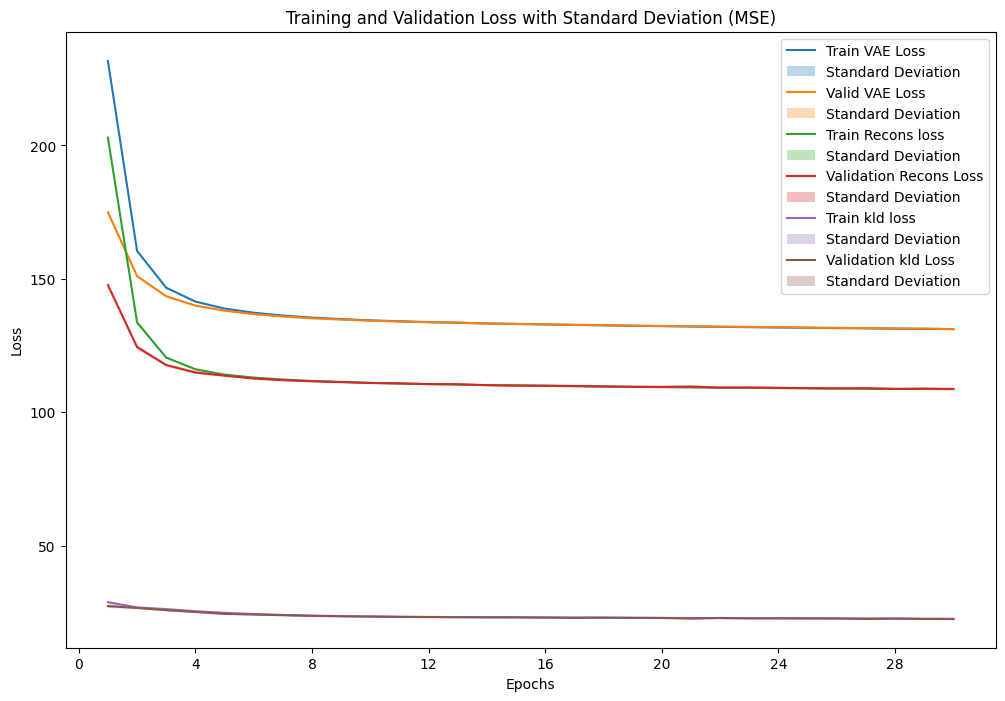

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_3_2 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_3_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_2['epochs'])
VAE_plot_mean_std(result_data_4_3_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_2['epochs'])
VAE_plot_mean_std(result_data_4_3_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_2['epochs'])
VAE_plot_mean_std(result_data_4_3_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_2['epochs'])
VAE_plot_mean_std(result_data_4_3_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_2['epochs'])
VAE_plot_mean_std(result_data_4_3_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_3_2['valid_metrics'],
    result_data_4_3_2['test_metrics'],
    result_data_4_3_2['valid_result'],
    result_data_4_3_2['test_result'],
    result_data_4_3_2['recons_valid_result'],
    result_data_4_3_2['recons_test_result'],
    result_data_4_3_2['kld_valid_result'],
    result_data_4_3_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.024859           0.024303           131.160238     129.735700              108.709190        108.709190            22.451048      22.545511
Standard Deviation                 0.000110           0.000094             0.383454       0.188054                0.336359          0.336359             0.259278       0.224647

Detailed Evaluation Table:


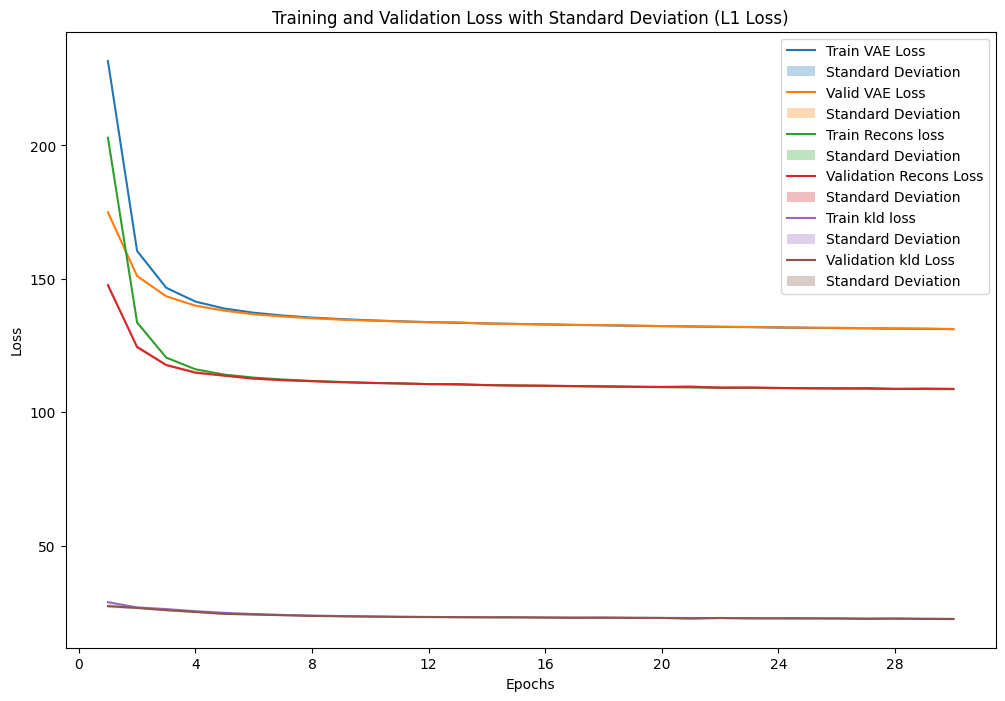

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_3_3 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_3_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_3['epochs'])
VAE_plot_mean_std(result_data_4_3_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_3['epochs'])
VAE_plot_mean_std(result_data_4_3_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_3['epochs'])
VAE_plot_mean_std(result_data_4_3_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_3['epochs'])
VAE_plot_mean_std(result_data_4_3_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_3['epochs'])
VAE_plot_mean_std(result_data_4_3_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_3_3['valid_metrics'],
    result_data_4_3_3['test_metrics'],
    result_data_4_3_3['valid_result'],
    result_data_4_3_3['test_result'],
    result_data_4_3_3['recons_valid_result'],
    result_data_4_3_3['recons_test_result'],
    result_data_4_3_3['kld_valid_result'],
    result_data_4_3_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.065170           0.064226           131.154259     129.788282              108.703212        108.703212            22.451048      22.545511
Standard Deviation                 0.000402           0.000397             0.404220       0.152259                0.328825          0.328825             0.259278       0.224647

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_3 = sum(p.numel() for p in models_4_3[0].parameters())
print(f"Number of parameters in the model: {total_params_4_3}")

Number of parameters in the model: 38448


### Experiment 3.4 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_4 = 'VAE'
model_config_4_4 = {'D_x': 784, 'n_layers': 1, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_4, fold_results_4_4 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_4),
                                                model_config=model_config_4_4,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:212.279591, Training Recons Loss: 180.164387, Training KLD Loss: 32.115204
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.031286921292701934, 'L1 Loss': 0.09247832840427439, 'BCE': 0.16704934550092576}, Validation VAE Loss: {'MSE': 161.63166046142578, 'L1 Loss': 161.56619993169258, 'BCE': 161.64687038989777}, Validation Recons Loss: {'MSE': 130.95147705078125, 'L1 Loss': 130.88601676453936, 'BCE': 130.96668697925324}, Validation KLD Loss: {'MSE': 30.68018347151736, 'L1 Loss': 30.68018347151736, 'BCE': 30.68018347151736}
Train Fold/Epoch: 1/2, Training Loss:149.168206, Training Recons Loss: 116.331010, Training KLD Loss: 32.837196
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.022412208602466482, 'L1 Loss': 0.06847363329948263, 'BCE': 0.13624278360858877}, Validation VAE Loss: {'MSE

## Visualizing reconstructions for all fold

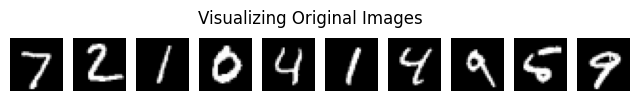

Visualizing reconstructions for fold 1


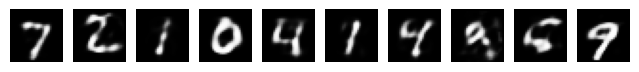

Visualizing reconstructions for fold 2


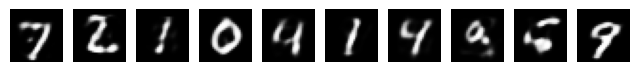

Visualizing reconstructions for fold 3


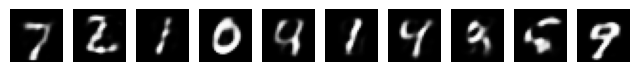

Visualizing reconstructions for fold 4


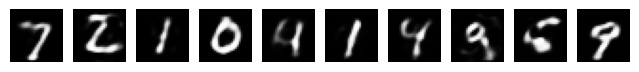

Visualizing reconstructions for fold 5


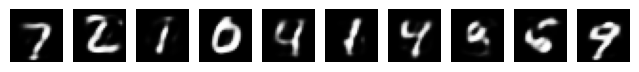

Visualizing reconstructions for fold 6


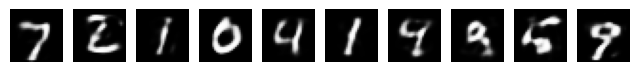

Visualizing reconstructions for fold 7


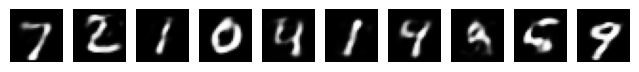

Visualizing reconstructions for fold 8


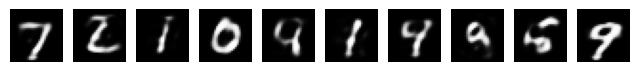

Visualizing reconstructions for fold 9


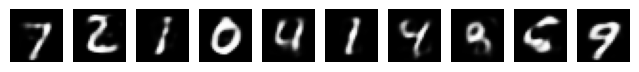

Visualizing reconstructions for fold 10


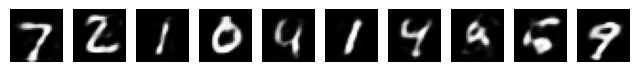

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_4):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

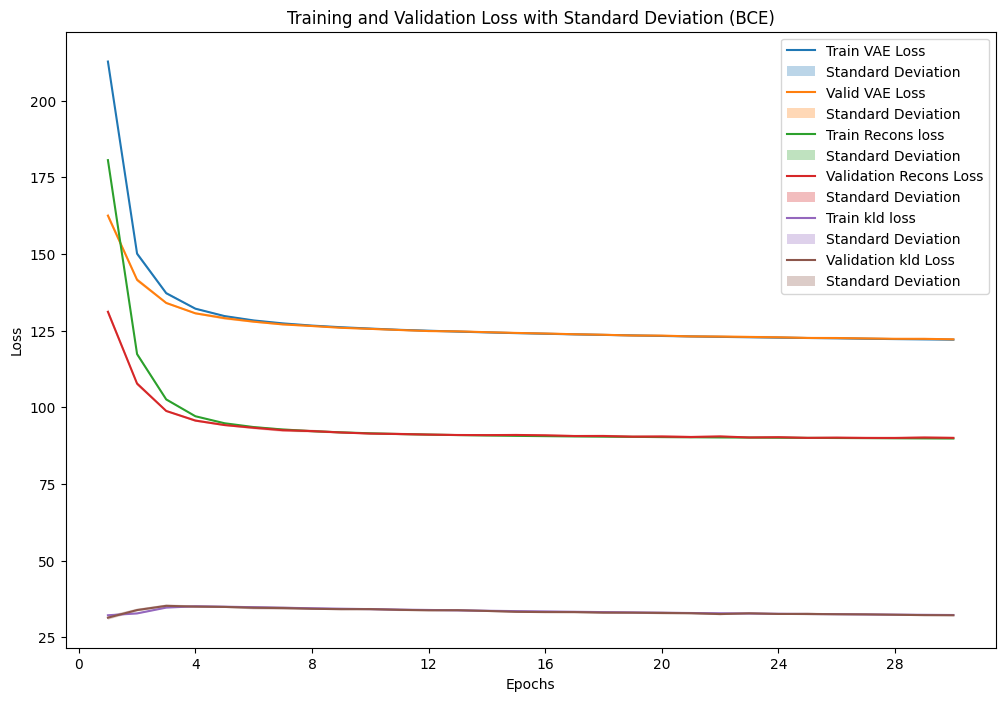

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_4_1 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_4_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_1['epochs'])
VAE_plot_mean_std(result_data_4_4_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_1['epochs'])
VAE_plot_mean_std(result_data_4_4_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_1['epochs'])
VAE_plot_mean_std(result_data_4_4_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_1['epochs'])
VAE_plot_mean_std(result_data_4_4_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_1['epochs'])
VAE_plot_mean_std(result_data_4_4_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_4_1['valid_metrics'],
    result_data_4_4_1['test_metrics'],
    result_data_4_4_1['valid_result'],
    result_data_4_4_1['test_result'],
    result_data_4_4_1['recons_valid_result'],
    result_data_4_4_1['recons_test_result'],
    result_data_4_4_1['kld_valid_result'],
    result_data_4_4_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.114784           0.113037           122.134255     120.794903               89.990903         89.990903            32.143352      32.174002
Standard Deviation                 0.000397           0.000186             0.250181       0.130069                0.310860          0.310860             0.203844       0.202820

Detailed Evaluation Table:


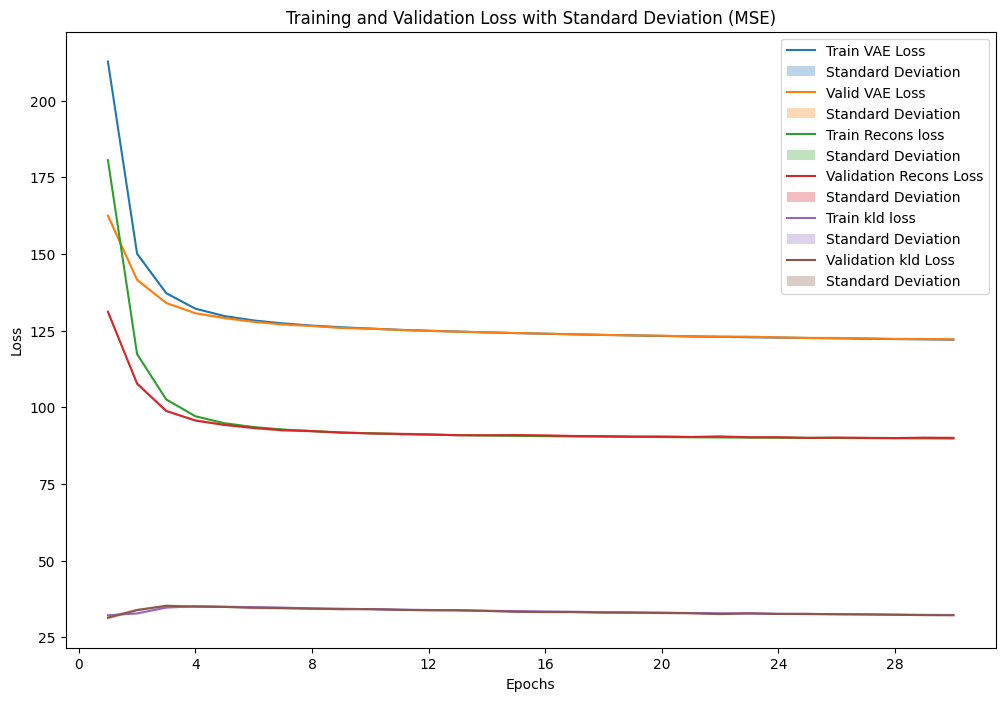

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_4_2 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_4_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_2['epochs'])
VAE_plot_mean_std(result_data_4_4_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_2['epochs'])
VAE_plot_mean_std(result_data_4_4_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_2['epochs'])
VAE_plot_mean_std(result_data_4_4_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_2['epochs'])
VAE_plot_mean_std(result_data_4_4_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_2['epochs'])
VAE_plot_mean_std(result_data_4_4_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_4_2['valid_metrics'],
    result_data_4_4_2['test_metrics'],
    result_data_4_4_2['valid_result'],
    result_data_4_4_2['test_result'],
    result_data_4_4_2['recons_valid_result'],
    result_data_4_4_2['recons_test_result'],
    result_data_4_4_2['kld_valid_result'],
    result_data_4_4_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.016936           0.016432           122.141875     120.755542               89.998523         89.998523            32.143352      32.174002
Standard Deviation                 0.000108           0.000085             0.275884       0.103684                0.333751          0.333751             0.203844       0.202820

Detailed Evaluation Table:


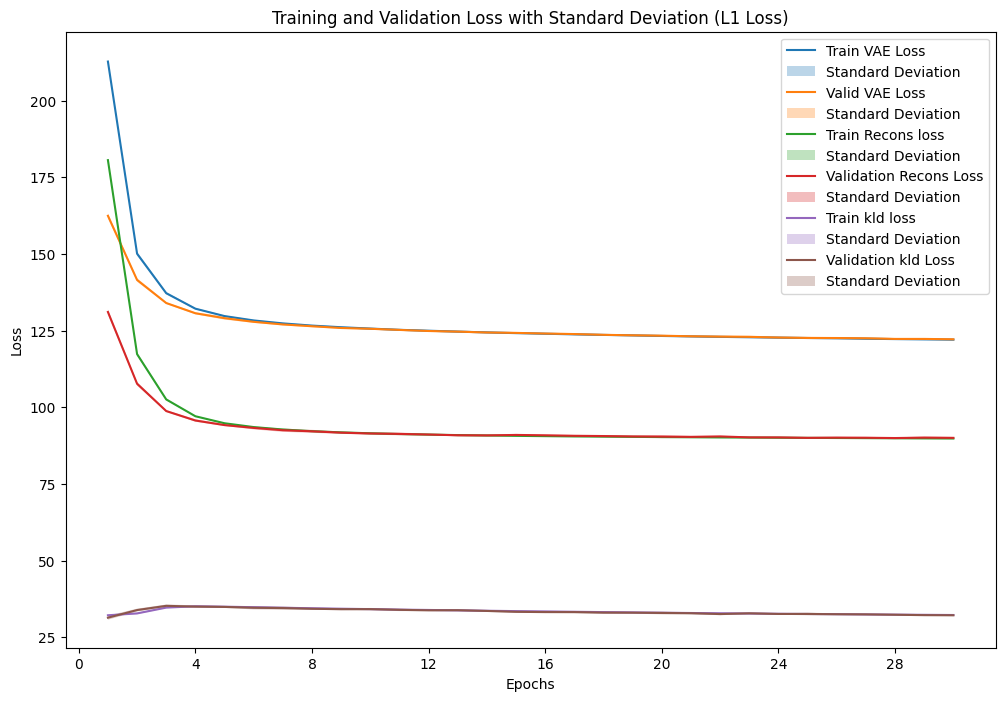

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_4_3 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_4_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_3['epochs'])
VAE_plot_mean_std(result_data_4_4_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_3['epochs'])
VAE_plot_mean_std(result_data_4_4_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_3['epochs'])
VAE_plot_mean_std(result_data_4_4_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_3['epochs'])
VAE_plot_mean_std(result_data_4_4_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_3['epochs'])
VAE_plot_mean_std(result_data_4_4_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_4_3['valid_metrics'],
    result_data_4_4_3['test_metrics'],
    result_data_4_4_3['valid_result'],
    result_data_4_4_3['test_result'],
    result_data_4_4_3['recons_valid_result'],
    result_data_4_4_3['recons_test_result'],
    result_data_4_4_3['kld_valid_result'],
    result_data_4_4_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.049104           0.048201           122.142765     120.758026               89.999413         89.999413            32.143352      32.174002
Standard Deviation                 0.000249           0.000181             0.254197       0.151474                0.328572          0.328572             0.203844       0.202820

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_4 = sum(p.numel() for p in models_4_4[0].parameters())
print(f"Number of parameters in the model: {total_params_4_4}")

Number of parameters in the model: 76112


### Experiment 3.5 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_5 = 'VAE'
model_config_4_5 = {'D_x': 784, 'n_layers': 1, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_5, fold_results_4_5 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_5),
                                                model_config=model_config_4_5,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:199.507234, Training Recons Loss: 166.168718, Training KLD Loss: 33.338516
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.029312555004466088, 'L1 Loss': 0.08278687028808797, 'BCE': 0.15728599070868593}, Validation VAE Loss: {'MSE': 156.58955026180186, 'L1 Loss': 156.7678087924389, 'BCE': 156.72278497574177}, Validation Recons Loss: {'MSE': 123.17898275497112, 'L1 Loss': 123.35724087978932, 'BCE': 123.31221673843709}, Validation KLD Loss: {'MSE': 33.4105681967228, 'L1 Loss': 33.4105681967228, 'BCE': 33.4105681967228}
Train Fold/Epoch: 1/2, Training Loss:147.601885, Training Recons Loss: 112.314508, Training KLD Loss: 35.287377
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.022180899482299673, 'L1 Loss': 0.06474902322317691, 'BCE': 0.13364120921555986}, Validation VAE Loss: {'MSE': 1

## Visualizing reconstructions for all fold

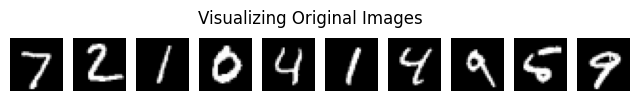

Visualizing reconstructions for fold 1


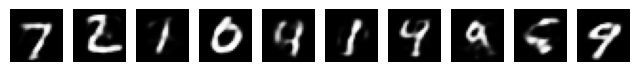

Visualizing reconstructions for fold 2


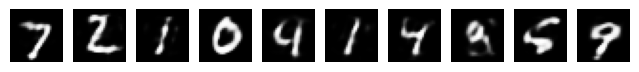

Visualizing reconstructions for fold 3


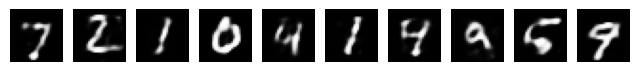

Visualizing reconstructions for fold 4


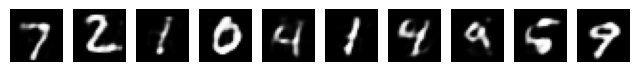

Visualizing reconstructions for fold 5


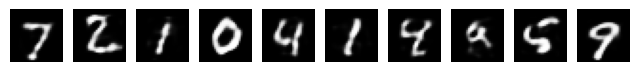

Visualizing reconstructions for fold 6


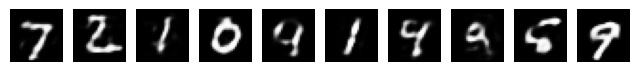

Visualizing reconstructions for fold 7


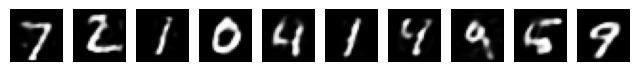

Visualizing reconstructions for fold 8


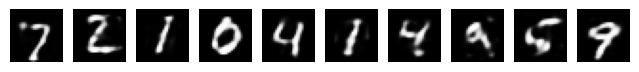

Visualizing reconstructions for fold 9


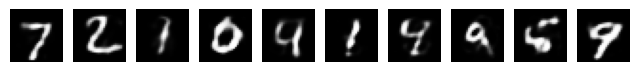

Visualizing reconstructions for fold 10


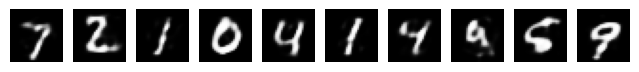

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_5):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

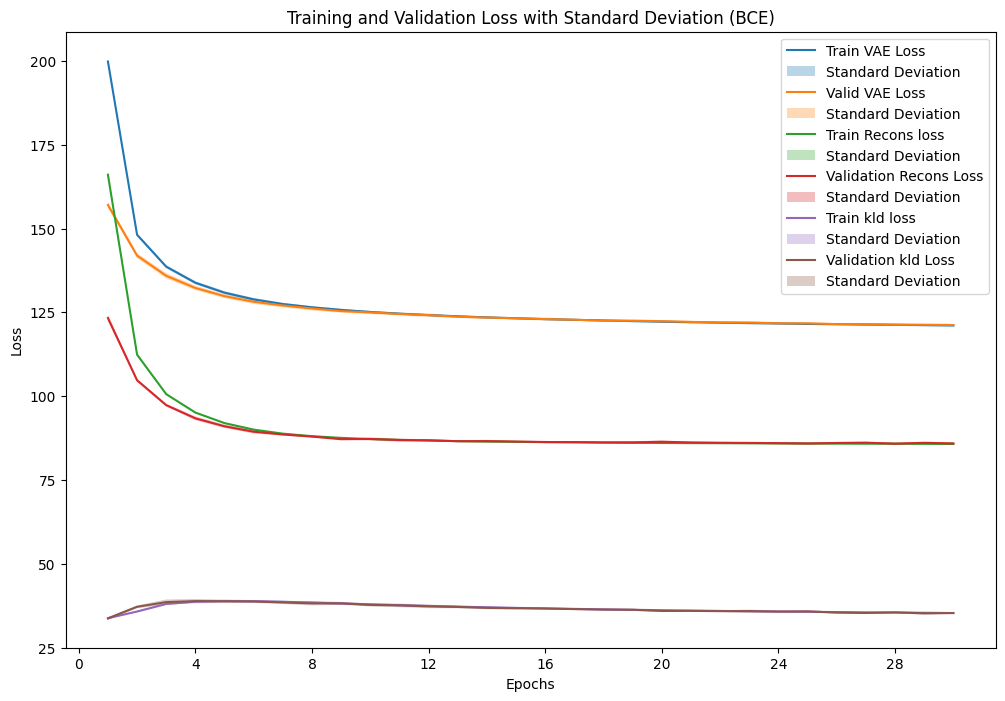

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_5_1 = VAE_plot_results(fold_results_4_5, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_5_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_5_1['epochs'])
VAE_plot_mean_std(result_data_4_5_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_5_1['epochs'])
VAE_plot_mean_std(result_data_4_5_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_5_1['epochs'])
VAE_plot_mean_std(result_data_4_5_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_5_1['epochs'])
VAE_plot_mean_std(result_data_4_5_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_5_1['epochs'])
VAE_plot_mean_std(result_data_4_5_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_5_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_5_1['valid_metrics'],
    result_data_4_5_1['test_metrics'],
    result_data_4_5_1['valid_result'],
    result_data_4_5_1['test_result'],
    result_data_4_5_1['recons_valid_result'],
    result_data_4_5_1['recons_test_result'],
    result_data_4_5_1['kld_valid_result'],
    result_data_4_5_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.109525           0.108042           121.189881     119.973720               85.867970         85.867970            35.321910      35.269001
Standard Deviation                 0.000464           0.000376             0.258746       0.116665                0.363953          0.363953             0.252221       0.278357

Detailed Evaluation Table:


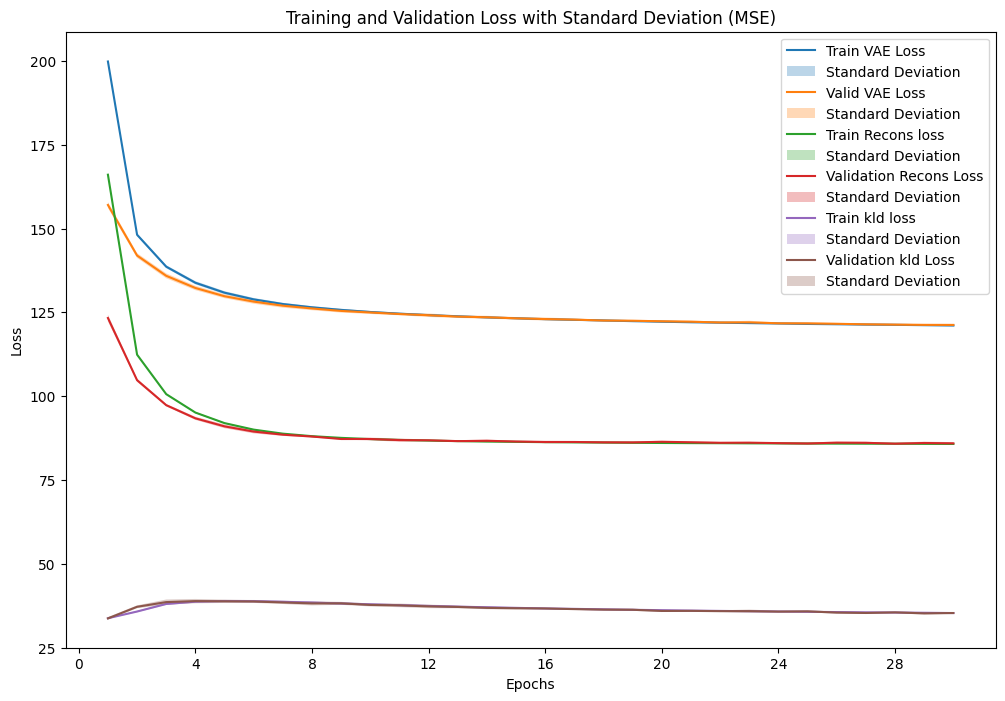

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_5_2 = VAE_plot_results(fold_results_4_5, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_5_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_5_2['epochs'])
VAE_plot_mean_std(result_data_4_5_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_5_2['epochs'])
VAE_plot_mean_std(result_data_4_5_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_5_2['epochs'])
VAE_plot_mean_std(result_data_4_5_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_5_2['epochs'])
VAE_plot_mean_std(result_data_4_5_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_5_2['epochs'])
VAE_plot_mean_std(result_data_4_5_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_5_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_5_2['valid_metrics'],
    result_data_4_5_2['test_metrics'],
    result_data_4_5_2['valid_result'],
    result_data_4_5_2['test_result'],
    result_data_4_5_2['recons_valid_result'],
    result_data_4_5_2['recons_test_result'],
    result_data_4_5_2['kld_valid_result'],
    result_data_4_5_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.015204            0.01478           121.263799     119.996540               85.941888         85.941888            35.321910      35.269001
Standard Deviation                 0.000124            0.00012             0.288763       0.079188                0.407134          0.407134             0.252221       0.278357

Detailed Evaluation Table:


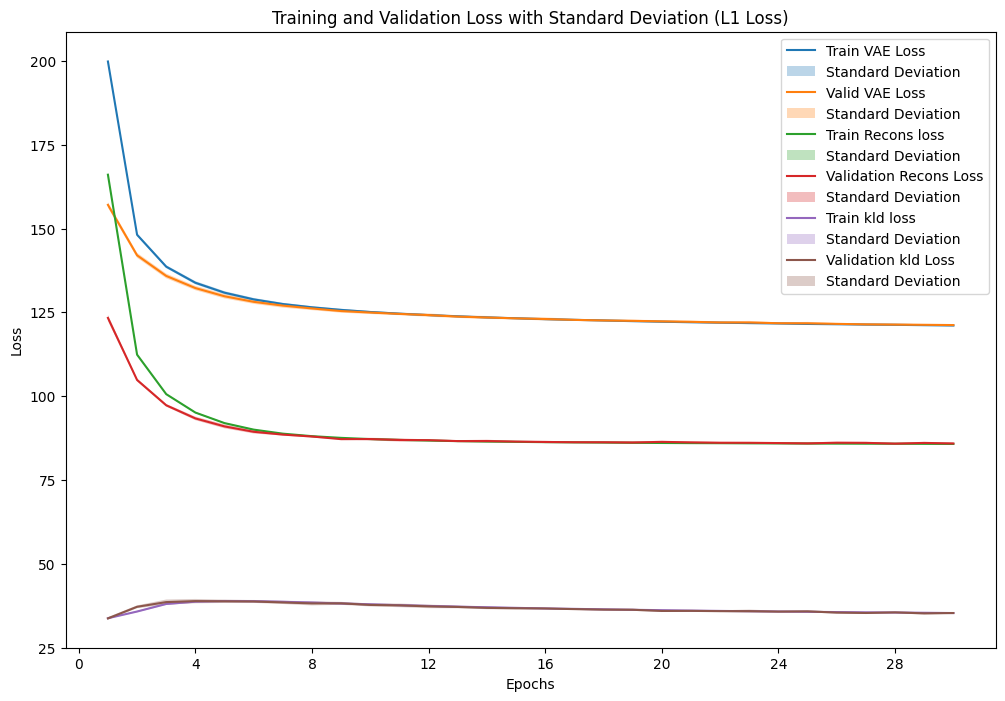

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_5_3 = VAE_plot_results(fold_results_4_5, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_5_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_5_3['epochs'])
VAE_plot_mean_std(result_data_4_5_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_5_3['epochs'])
VAE_plot_mean_std(result_data_4_5_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_5_3['epochs'])
VAE_plot_mean_std(result_data_4_5_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_5_3['epochs'])
VAE_plot_mean_std(result_data_4_5_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_5_3['epochs'])
VAE_plot_mean_std(result_data_4_5_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_5_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_5_3['valid_metrics'],
    result_data_4_5_3['test_metrics'],
    result_data_4_5_3['valid_result'],
    result_data_4_5_3['test_result'],
    result_data_4_5_3['recons_valid_result'],
    result_data_4_5_3['recons_test_result'],
    result_data_4_5_3['kld_valid_result'],
    result_data_4_5_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.045450           0.044682           121.248834     119.993384               85.926923         85.926923            35.321910      35.269001
Standard Deviation                 0.000257           0.000277             0.260360       0.093032                0.372046          0.372046             0.252221       0.278357

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_5 = sum(p.numel() for p in models_4_5[0].parameters())
print(f"Number of parameters in the model: {total_params_4_5}")

Number of parameters in the model: 151440


## Test 2 VAE: BCE

### Experiments 2 : VAE with $\beta$ =1 with n_layer =2

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 2, considering likelihoods modeled as Bernoulli.

### Experiment 4.6 : VAE with 2 layer

- Model: VAE of 2 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_6 = 'VAE'
model_config_4_6 = {'D_x': 784, 'n_layers': 2, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_6, fold_results_4_6 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_6),
                                                model_config=model_config_4_6,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:181.998808, Training Recons Loss: 176.360562, Training KLD Loss: 5.638247
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.049820800688355524, 'L1 Loss': 0.11545340027263824, 'BCE': 0.20751568231176823}, Validation VAE Loss: {'MSE': 167.92733310131317, 'L1 Loss': 168.0266059713161, 'BCE': 167.90111541748047}, Validation Recons Loss: {'MSE': 162.71851251480427, 'L1 Loss': 162.81778554713472, 'BCE': 162.69229483097158}, Validation KLD Loss: {'MSE': 5.208821103927937, 'L1 Loss': 5.208821103927937, 'BCE': 5.208821103927937}
Train Fold/Epoch: 1/2, Training Loss:165.316461, Training Recons Loss: 160.097136, Training KLD Loss: 5.219325
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.04789013847550179, 'L1 Loss': 0.11141990030065496, 'BCE': 0.2020236835517782}, Validation VAE Loss: {'MSE': 16

## Visualizing reconstructions for all fold

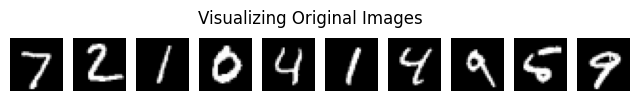

Visualizing reconstructions for fold 1


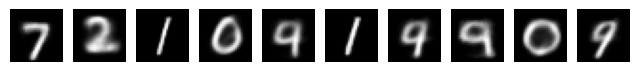

Visualizing reconstructions for fold 2


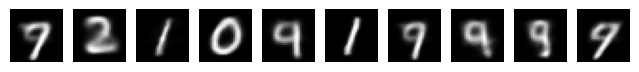

Visualizing reconstructions for fold 3


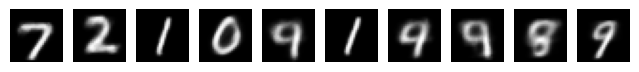

Visualizing reconstructions for fold 4


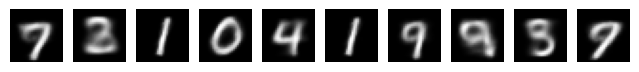

Visualizing reconstructions for fold 5


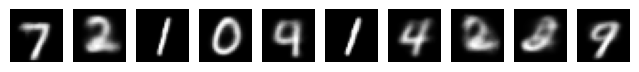

Visualizing reconstructions for fold 6


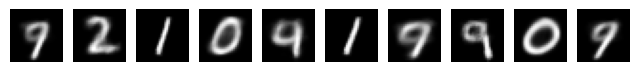

Visualizing reconstructions for fold 7


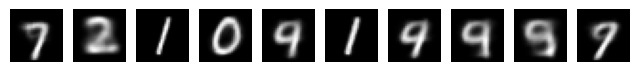

Visualizing reconstructions for fold 8


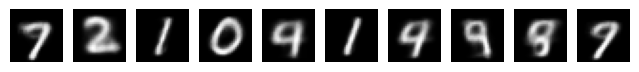

Visualizing reconstructions for fold 9


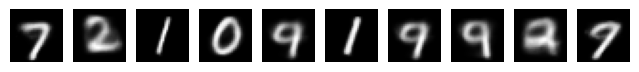

Visualizing reconstructions for fold 10


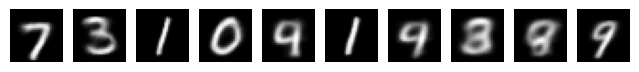

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_6):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

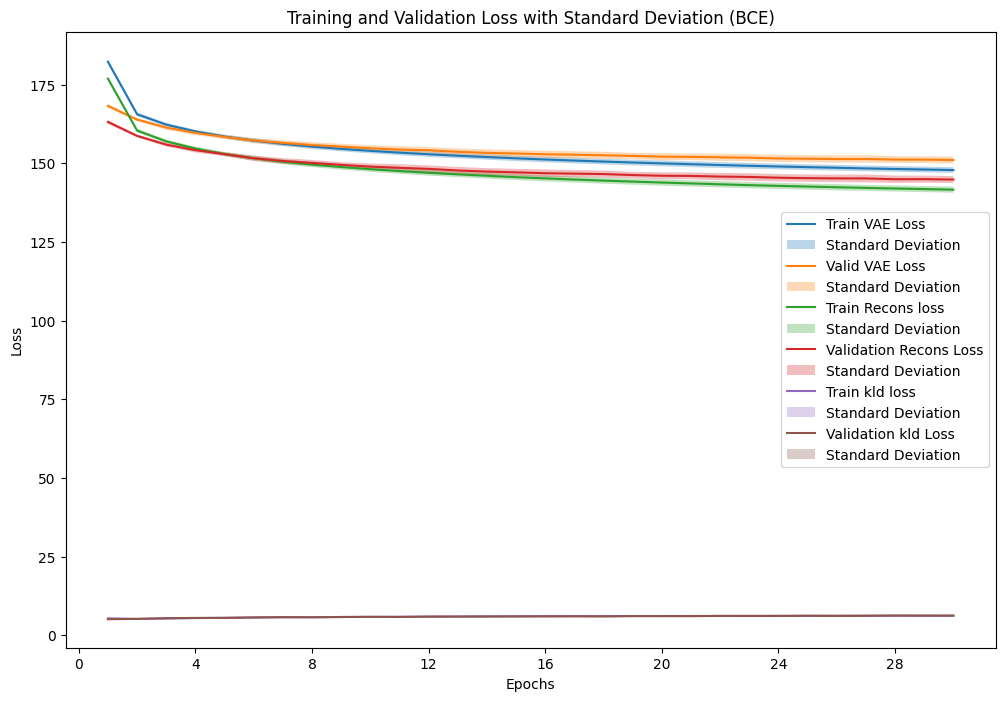

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_6_1 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_6_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_1['epochs'])
VAE_plot_mean_std(result_data_4_6_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_1['epochs'])
VAE_plot_mean_std(result_data_4_6_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_1['epochs'])
VAE_plot_mean_std(result_data_4_6_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_1['epochs'])
VAE_plot_mean_std(result_data_4_6_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_1['epochs'])
VAE_plot_mean_std(result_data_4_6_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_6_1['valid_metrics'],
    result_data_4_6_1['test_metrics'],
    result_data_4_6_1['valid_result'],
    result_data_4_6_1['test_result'],
    result_data_4_6_1['recons_valid_result'],
    result_data_4_6_1['recons_test_result'],
    result_data_4_6_1['kld_valid_result'],
    result_data_4_6_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.184722           0.184430           151.022630     150.770985              144.822142        144.822142             6.200489       6.178225
Standard Deviation                 0.001426           0.001378             1.127332       1.095337                1.117606          1.117606             0.119673       0.110909

Detailed Evaluation Table:


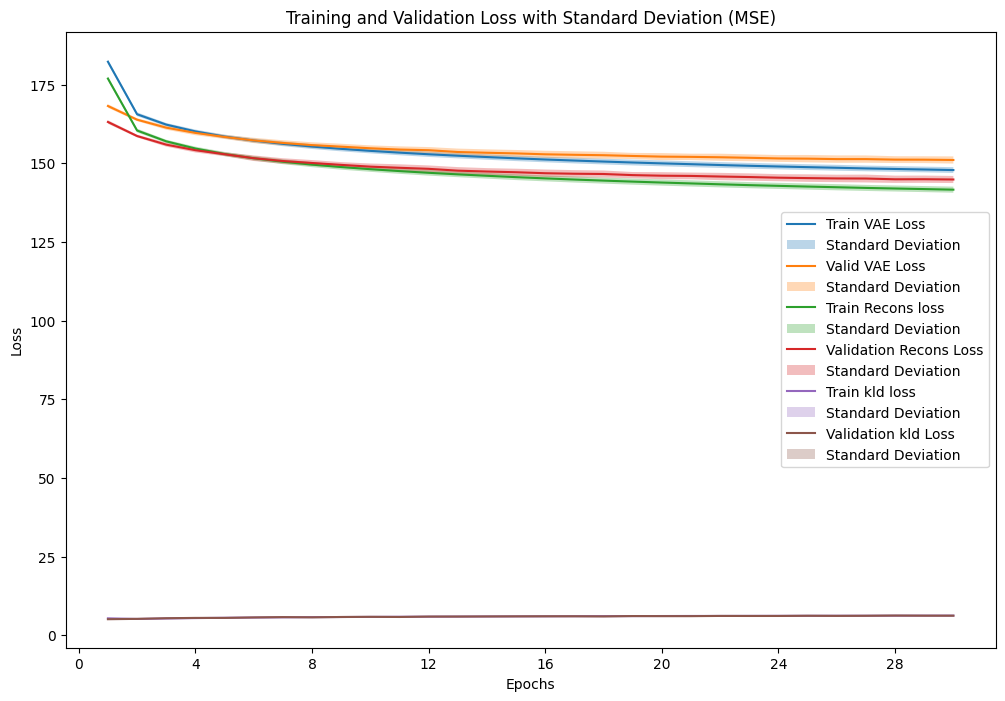

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_6_2 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_6_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_2['epochs'])
VAE_plot_mean_std(result_data_4_6_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_2['epochs'])
VAE_plot_mean_std(result_data_4_6_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_2['epochs'])
VAE_plot_mean_std(result_data_4_6_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_2['epochs'])
VAE_plot_mean_std(result_data_4_6_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_2['epochs'])
VAE_plot_mean_std(result_data_4_6_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_6_2['valid_metrics'],
    result_data_4_6_2['test_metrics'],
    result_data_4_6_2['valid_result'],
    result_data_4_6_2['test_result'],
    result_data_4_6_2['recons_valid_result'],
    result_data_4_6_2['recons_test_result'],
    result_data_4_6_2['kld_valid_result'],
    result_data_4_6_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.041428           0.041432           151.023536     150.772285              144.823048        144.823048             6.200489       6.178225
Standard Deviation                 0.000510           0.000540             1.138872       1.065374                1.125606          1.125606             0.119673       0.110909

Detailed Evaluation Table:


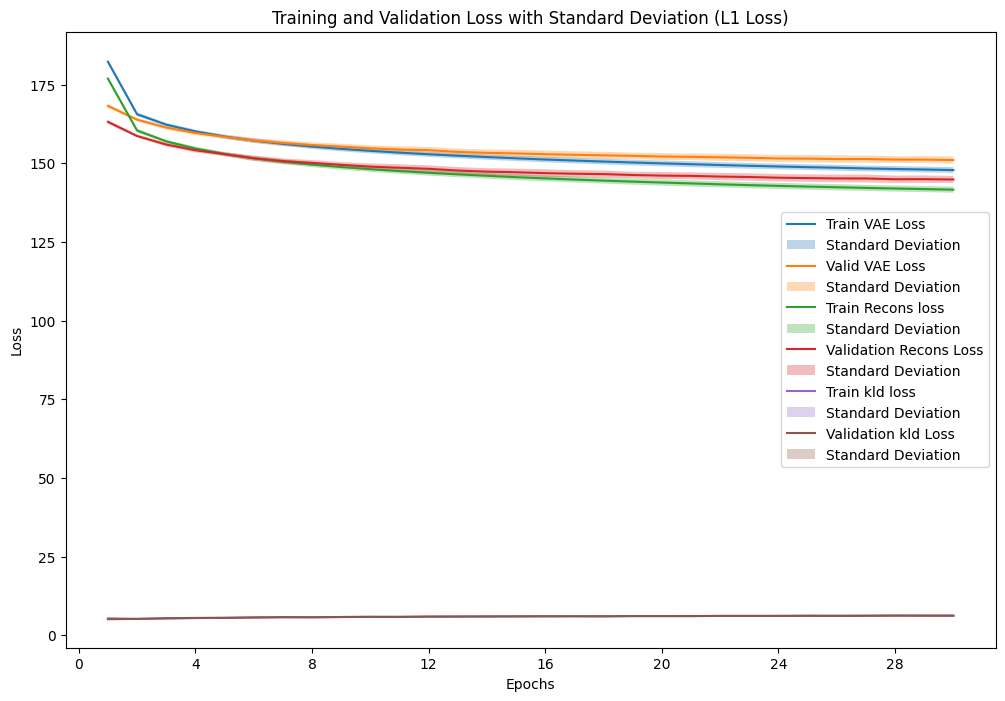

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_6_3 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_6_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_3['epochs'])
VAE_plot_mean_std(result_data_4_6_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_3['epochs'])
VAE_plot_mean_std(result_data_4_6_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_3['epochs'])
VAE_plot_mean_std(result_data_4_6_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_3['epochs'])
VAE_plot_mean_std(result_data_4_6_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_3['epochs'])
VAE_plot_mean_std(result_data_4_6_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_6_3['valid_metrics'],
    result_data_4_6_3['test_metrics'],
    result_data_4_6_3['valid_result'],
    result_data_4_6_3['test_result'],
    result_data_4_6_3['recons_valid_result'],
    result_data_4_6_3['recons_test_result'],
    result_data_4_6_3['kld_valid_result'],
    result_data_4_6_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.097248           0.097301           151.026076     150.787946              144.825587        144.825587             6.200489       6.178225
Standard Deviation                 0.001072           0.001079             1.146629       1.097656                1.136253          1.136253             0.119673       0.110909

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_6 = sum(p.numel() for p in models_4_6[0].parameters())
print(f"Number of parameters in the model: {total_params_4_6}")

Number of parameters in the model: 620156


<ipython-input-17-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


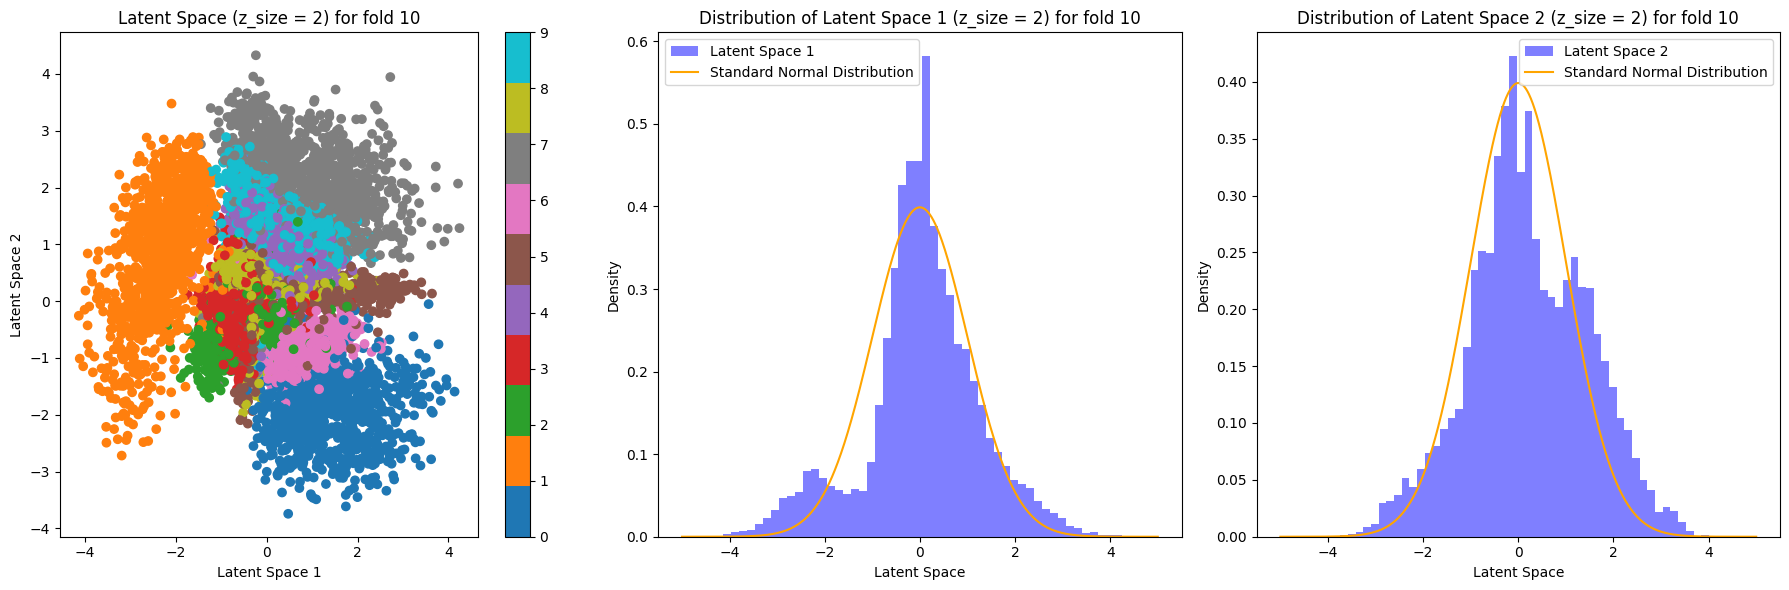

In [ ]:
latent_space_VAE_model(models_4_6[9], test_loader, device, number_fold=10)

### Experiment 3.2 : AE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=8, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_7 = 'VAE'
model_config_4_7 = {'D_x': 784, 'n_layers': 2, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_7, fold_results_4_7 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_7),
                                                model_config=model_config_4_7,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:148.917197, Training Recons Loss: 131.991981, Training KLD Loss: 16.925216
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.021610887166350446, 'L1 Loss': 0.0592718945538744, 'BCE': 0.12796912263048457}, Validation VAE Loss: {'MSE': 121.02323191216651, 'L1 Loss': 120.9614909557586, 'BCE': 120.92028565102436}, Validation Recons Loss: {'MSE': 100.4307384085148, 'L1 Loss': 100.36899720861557, 'BCE': 100.32779182271754}, Validation KLD Loss: {'MSE': 20.592493828306807, 'L1 Loss': 20.592493828306807, 'BCE': 20.592493828306807}
Train Fold/Epoch: 1/2, Training Loss:116.942789, Training Recons Loss: 95.171026, Training KLD Loss: 21.771763
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.018353933508091783, 'L1 Loss': 0.052140473883519785, 'BCE': 0.11825714410936579}, Validation VAE Loss: {'MSE

## Visualizing reconstructions for all fold

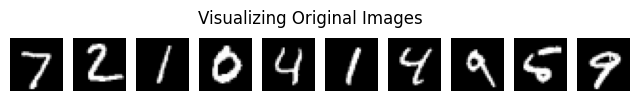

Visualizing reconstructions for fold 1


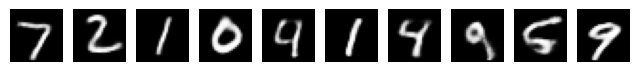

Visualizing reconstructions for fold 2


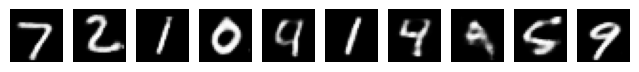

Visualizing reconstructions for fold 3


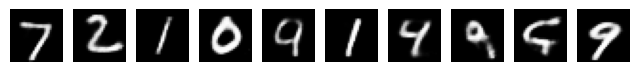

Visualizing reconstructions for fold 4


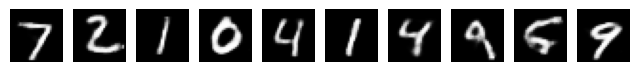

Visualizing reconstructions for fold 5


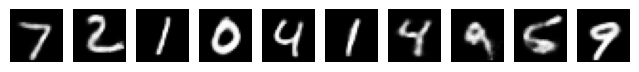

Visualizing reconstructions for fold 6


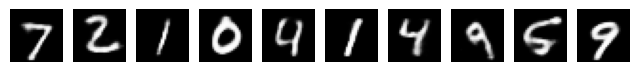

Visualizing reconstructions for fold 7


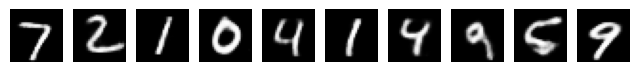

Visualizing reconstructions for fold 8


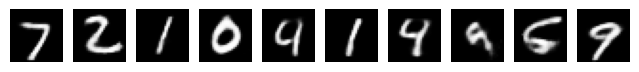

Visualizing reconstructions for fold 9


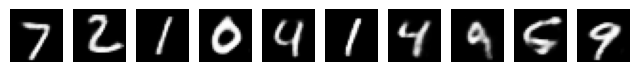

Visualizing reconstructions for fold 10


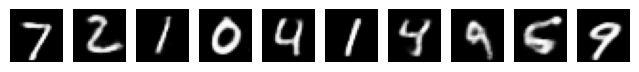

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_7):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

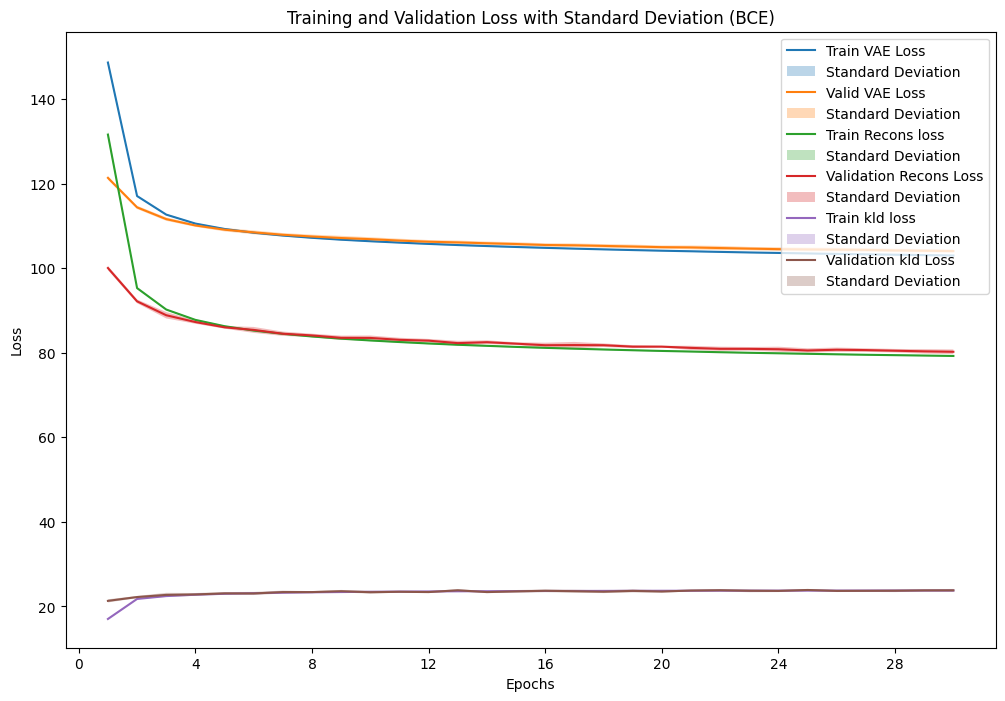

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_7_1 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_7_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_1['epochs'])
VAE_plot_mean_std(result_data_4_7_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_1['epochs'])
VAE_plot_mean_std(result_data_4_7_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_1['epochs'])
VAE_plot_mean_std(result_data_4_7_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_1['epochs'])
VAE_plot_mean_std(result_data_4_7_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_1['epochs'])
VAE_plot_mean_std(result_data_4_7_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_7_1['valid_metrics'],
    result_data_4_7_1['test_metrics'],
    result_data_4_7_1['valid_result'],
    result_data_4_7_1['test_result'],
    result_data_4_7_1['recons_valid_result'],
    result_data_4_7_1['recons_test_result'],
    result_data_4_7_1['kld_valid_result'],
    result_data_4_7_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.102318           0.101194           104.027566     103.148355               80.217651         80.217651            23.809915      23.812275
Standard Deviation                 0.000711           0.000515             0.372136       0.158325                0.557148          0.557148             0.326069       0.313514

Detailed Evaluation Table:


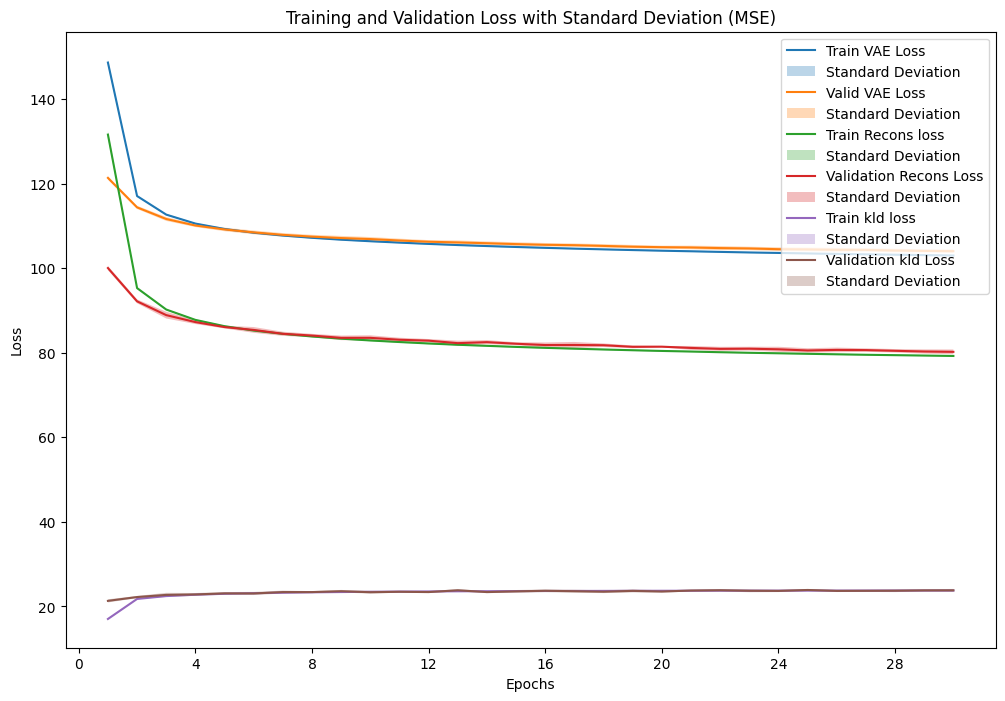

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_7_2 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_7_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_2['epochs'])
VAE_plot_mean_std(result_data_4_7_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_2['epochs'])
VAE_plot_mean_std(result_data_4_7_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_2['epochs'])
VAE_plot_mean_std(result_data_4_7_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_2['epochs'])
VAE_plot_mean_std(result_data_4_7_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_2['epochs'])
VAE_plot_mean_std(result_data_4_7_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_7_2['valid_metrics'],
    result_data_4_7_2['test_metrics'],
    result_data_4_7_2['valid_result'],
    result_data_4_7_2['test_result'],
    result_data_4_7_2['recons_valid_result'],
    result_data_4_7_2['recons_test_result'],
    result_data_4_7_2['kld_valid_result'],
    result_data_4_7_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.013299           0.013014           103.991387     103.117176               80.181471         80.181471            23.809915      23.812275
Standard Deviation                 0.000195           0.000155             0.402485       0.150797                0.578999          0.578999             0.326069       0.313514

Detailed Evaluation Table:


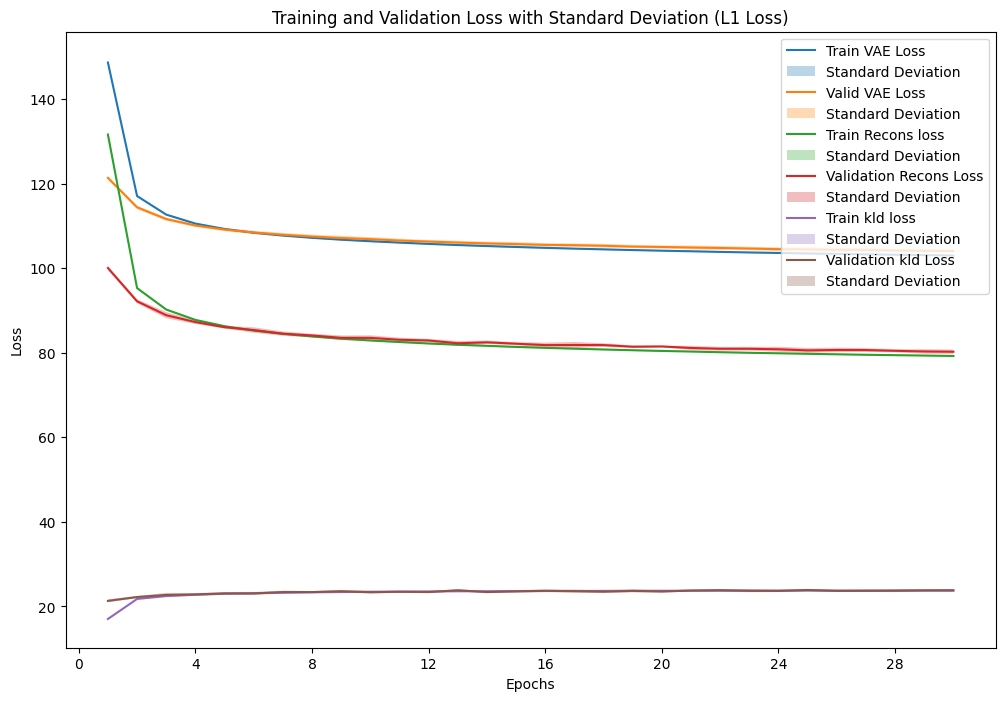

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_7_3 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_7_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_3['epochs'])
VAE_plot_mean_std(result_data_4_7_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_3['epochs'])
VAE_plot_mean_std(result_data_4_7_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_3['epochs'])
VAE_plot_mean_std(result_data_4_7_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_3['epochs'])
VAE_plot_mean_std(result_data_4_7_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_3['epochs'])
VAE_plot_mean_std(result_data_4_7_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_7_3['valid_metrics'],
    result_data_4_7_3['test_metrics'],
    result_data_4_7_3['valid_result'],
    result_data_4_7_3['test_result'],
    result_data_4_7_3['recons_valid_result'],
    result_data_4_7_3['recons_test_result'],
    result_data_4_7_3['kld_valid_result'],
    result_data_4_7_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                  0.04076           0.040173           104.009911     103.160113               80.199996         80.199996            23.809915      23.812275
Standard Deviation                  0.00030           0.000257             0.395085       0.144232                0.572529          0.572529             0.326069       0.313514

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_7 = sum(p.numel() for p in models_4_7[0].parameters())
print(f"Number of parameters in the model: {total_params_4_7}")

Number of parameters in the model: 648016


### Experiment 3.3 : AE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_8 = 'VAE'
model_config_4_8 = {'D_x': 784, 'n_layers': 2, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_8, fold_results_4_8 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_8),
                                                model_config=model_config_4_8,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:152.816727, Training Recons Loss: 134.769586, Training KLD Loss: 18.047141
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.022270691224393693, 'L1 Loss': 0.06019137930521305, 'BCE': 0.13003979013004202}, Validation VAE Loss: {'MSE': 125.42055884827958, 'L1 Loss': 125.50410161119827, 'BCE': 125.29698311014378}, Validation Recons Loss: {'MSE': 102.07477179993974, 'L1 Loss': 102.15831504984105, 'BCE': 101.95119598064016}, Validation KLD Loss: {'MSE': 23.345786886012302, 'L1 Loss': 23.345786886012302, 'BCE': 23.345786886012302}
Train Fold/Epoch: 1/2, Training Loss:119.179335, Training Recons Loss: 94.695189, Training KLD Loss: 24.484146
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.017471522033373092, 'L1 Loss': 0.050466745061443205, 'BCE': 0.1153839573739691}, Validation VAE Loss: {'M

## Visualizing reconstructions for all fold

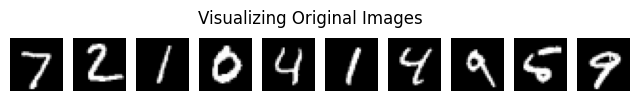

Visualizing reconstructions for fold 1


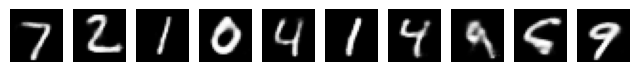

Visualizing reconstructions for fold 2


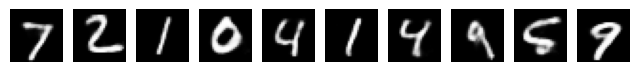

Visualizing reconstructions for fold 3


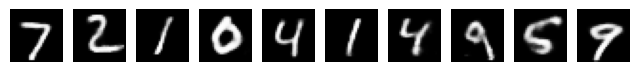

Visualizing reconstructions for fold 4


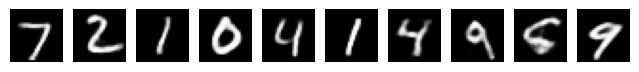

Visualizing reconstructions for fold 5


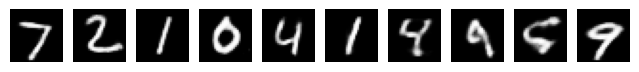

Visualizing reconstructions for fold 6


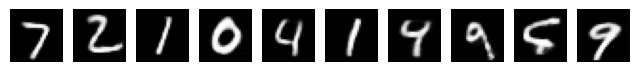

Visualizing reconstructions for fold 7


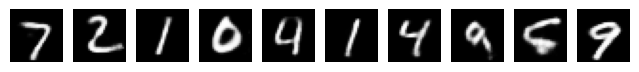

Visualizing reconstructions for fold 8


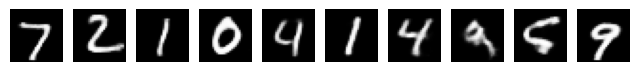

Visualizing reconstructions for fold 9


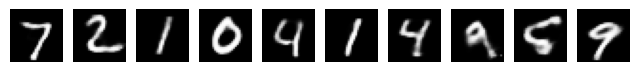

Visualizing reconstructions for fold 10


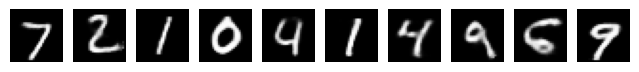

In [ ]:
VAE_visualize_original_images(test_loader, img_shape=(28, 28))
for fold_index, model_to_visualize in enumerate(models_4_8):
    print(f"Visualizing reconstructions for fold {fold_index + 1}")
    VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))


### Plot Training Loss and Validation Loss functions with Standard Deviation

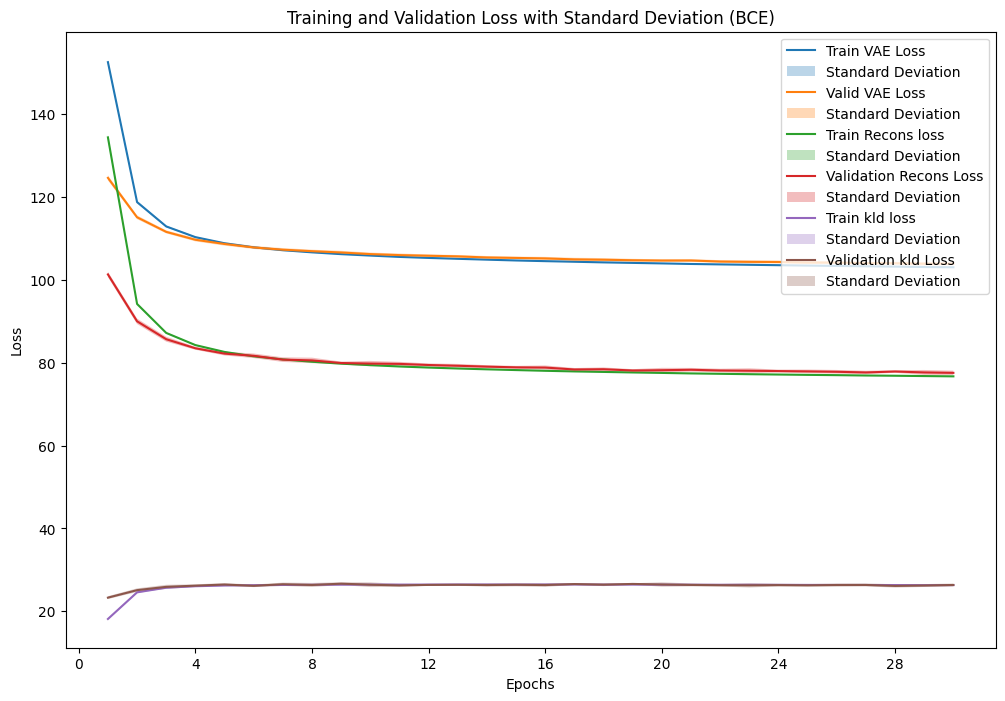

In [ ]:
loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
result_data_4_8_1 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_8_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_1['epochs'])
VAE_plot_mean_std(result_data_4_8_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_1['epochs'])
VAE_plot_mean_std(result_data_4_8_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_1['epochs'])
VAE_plot_mean_std(result_data_4_8_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_1['epochs'])
VAE_plot_mean_std(result_data_4_8_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_1['epochs'])
VAE_plot_mean_std(result_data_4_8_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_1['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_8_1['valid_metrics'],
    result_data_4_8_1['test_metrics'],
    result_data_4_8_1['valid_result'],
    result_data_4_8_1['test_result'],
    result_data_4_8_1['recons_valid_result'],
    result_data_4_8_1['recons_test_result'],
    result_data_4_8_1['kld_valid_result'],
    result_data_4_8_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.098988           0.097934           103.965552     103.089310               77.606446         77.606446            26.359106      26.308955
Standard Deviation                 0.000679           0.000546             0.354771       0.162017                0.532468          0.532468             0.351425       0.391666

Detailed Evaluation Table:


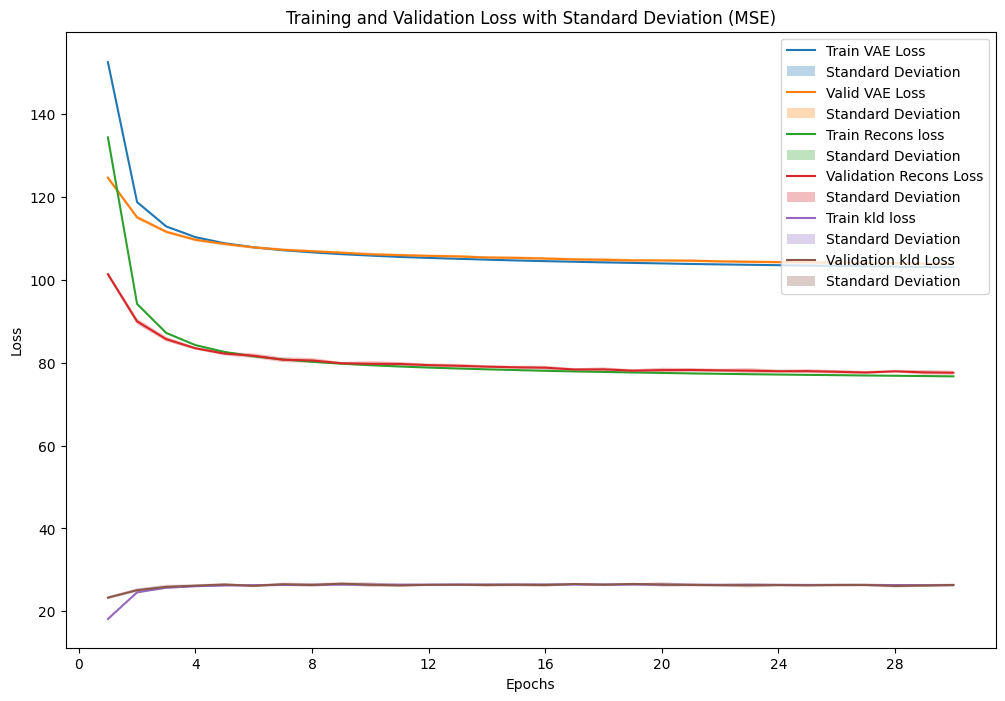

In [ ]:
loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
result_data_4_8_2 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_8_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_2['epochs'])
VAE_plot_mean_std(result_data_4_8_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_2['epochs'])
VAE_plot_mean_std(result_data_4_8_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_2['epochs'])
VAE_plot_mean_std(result_data_4_8_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_2['epochs'])
VAE_plot_mean_std(result_data_4_8_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_2['epochs'])
VAE_plot_mean_std(result_data_4_8_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_2['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_8_2['valid_metrics'],
    result_data_4_8_2['test_metrics'],
    result_data_4_8_2['valid_result'],
    result_data_4_8_2['test_result'],
    result_data_4_8_2['recons_valid_result'],
    result_data_4_8_2['recons_test_result'],
    result_data_4_8_2['kld_valid_result'],
    result_data_4_8_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.012213           0.011961           103.918051     103.052916               77.558945         77.558945            26.359106      26.308955
Standard Deviation                 0.000209           0.000181             0.334300       0.129486                0.517449          0.517449             0.351425       0.391666

Detailed Evaluation Table:


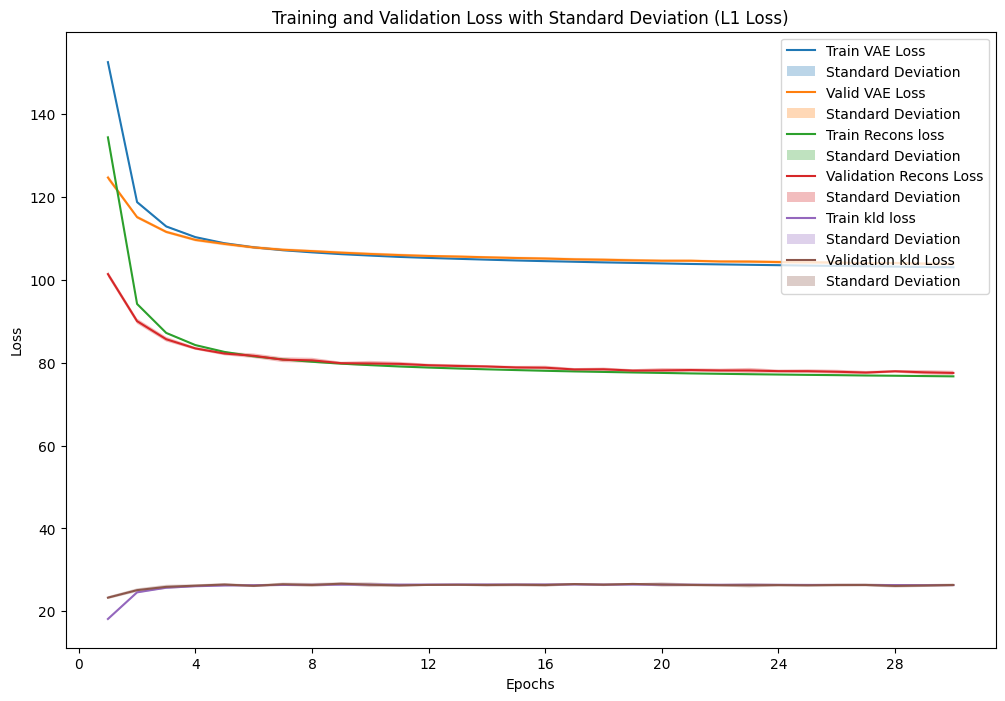

In [ ]:
loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
result_data_4_8_3 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

fig, ax = plt.subplots(figsize=(12, 8))
VAE_plot_mean_std(result_data_4_8_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_3['epochs'])
VAE_plot_mean_std(result_data_4_8_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_3['epochs'])
VAE_plot_mean_std(result_data_4_8_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_3['epochs'])
VAE_plot_mean_std(result_data_4_8_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_3['epochs'])
VAE_plot_mean_std(result_data_4_8_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_3['epochs'])
VAE_plot_mean_std(result_data_4_8_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_3['epochs'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
ax.legend()
plt.show()

In [ ]:
print_evaluation_table(
    result_data_4_8_3['valid_metrics'],
    result_data_4_8_3['test_metrics'],
    result_data_4_8_3['valid_result'],
    result_data_4_8_3['test_result'],
    result_data_4_8_3['recons_valid_result'],
    result_data_4_8_3['recons_test_result'],
    result_data_4_8_3['kld_valid_result'],
    result_data_4_8_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.038425           0.037871           103.898981     103.045469               77.539876         77.539876            26.359106      26.308955
Standard Deviation                 0.000319           0.000279             0.328458       0.118351                0.517797          0.517797             0.351425       0.391666

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_8 = sum(p.numel() for p in models_4_8[0].parameters())
print(f"Number of parameters in the model: {total_params_4_8}")

Number of parameters in the model: 680576
